<a href="https://colab.research.google.com/github/AgentQuantum/pneumonia-cnn/blob/main/Rishit_Lake_Summit_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will explore what lakes can be used for analysis.
We focus on two steps:
* Imputing missing values
* Using imputed datasets to forecast future values

## 1. Data Analysis

In [ ]:
!pip install scikit-learn xgboost
!pip install missingpy #missforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
#install
!pip install openpyxl


#mount drive
from google.colab import drive
drive.mount('/content/drive')

#import packages
import pandas as pd
import matplotlib.pyplot as plt


Mounted at /content/drive


In [ ]:
# Replace 'MyDrive/path/to/your/folder/your_file.xlsx' accordingly

# original file path used
# file_path = '/content/drive/MyDrive/Colby Research/Lake Modeling/MaineLakes_Su2025/SecchiDataDJW.xlsx'

file_path = '/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy of SecchiDataDJW.xlsx'

#read file
df = pd.read_excel(file_path, sheet_name= 'data', engine='openpyxl')
df.head()

MIDAS   SAMPDATE  SECCHI SECCBOT  TMAX  TMIN  DOMAX  DOMIN  MLD  OXIC  \
0  c-1-1 1992-05-27     6.5       N   NaN   NaN    NaN    NaN  NaN   NaN   
1  c-1-1 1992-06-10     7.5       N   NaN   NaN    NaN    NaN  NaN   NaN   
2  c-1-1 1992-06-24     8.5       Y   NaN   NaN    NaN    NaN  NaN   NaN   
3  c-1-1 1992-07-09     6.5       N   NaN   NaN    NaN    NaN  NaN   NaN   
4  c-1-1 1992-07-23     6.0       N   NaN   NaN    NaN    NaN  NaN   NaN   

   SCHMIDT  TPEC  TPBG  CHLA  PH  COLOR  CONDUCT  ALK  
0      NaN   NaN   NaN   NaN NaN    NaN      NaN  NaN  
1      NaN   NaN   NaN   NaN NaN    NaN      NaN  NaN  
2      NaN   NaN   NaN   NaN NaN    NaN      NaN  NaN  
3      NaN   NaN   NaN   NaN NaN    NaN      NaN  NaN  
4      NaN   NaN   NaN   NaN NaN    NaN      NaN  NaN

In [ ]:
#missing data
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def calculate_missing_percentages(df):
    """
    Calculates and returns the percentage of missing values in each column of the DataFrame.

    Parameters:
        df (pd.DataFrame): Input data

    Returns:
        pd.Series: Missing percentage per column
    """
    missing_percentages = df.isna().mean() * 100
    return missing_percentages.sort_values(ascending=False)

# Example usage:
# df = pd.read_csv('your_dataset.csv')  # Load your data
missing_percents = calculate_missing_percentages(df)
print(missing_percents)


TPBG        95.545355
CONDUCT     90.792796
PH          89.358846
COLOR       88.298246
ALK         86.903932
TPEC        82.551576
CHLA        81.030041
DOMAX       74.318666
OXIC        74.318666
DOMIN       74.318666
MLD         71.808772
SCHMIDT     71.808772
TMIN        71.808772
TMAX        71.808772
SECCBOT      0.222477
MIDAS        0.000000
SAMPDATE     0.000000
SECCHI       0.000000
dtype: float64


## Let's first isolate the lakes

In [ ]:
def subset_by_midas_prefix(df, midas_prefixes):
    """
    Subsets the DataFrame by MIDAS prefixes and prints counts for each matched full MIDAS entry.

    Parameters:
        df (pd.DataFrame): The main DataFrame containing a 'MIDAS' column
        midas_prefixes (list): List of MIDAS prefix strings like 'c5448', 'c9961'

    Returns:
        pd.DataFrame: Subset of the original DataFrame containing matched rows
    """
    # Ensure MIDAS column is string
    df['MIDAS'] = df['MIDAS'].astype(str)

    # Keep rows where MIDAS starts with any of the prefixes
    mask = df['MIDAS'].apply(lambda x: any(x.startswith(prefix) for prefix in midas_prefixes))
    df_subset = df[mask].copy()

    # Print count of entries for each unique matched MIDAS
    print("Matched MIDAS entries and their counts:")
    for midas_val, count in df_subset['MIDAS'].value_counts().items():
        print(f"{midas_val}: {count} rows")

    return df_subset


In [ ]:
midas_list = [
    'c5448', 'c9961', 'c5400', 'c3714', 'c5780',
    'c5236', 'c5349', 'c3814', 'c3748', 'c1802'
]

df_subset = subset_by_midas_prefix(df, midas_list)


Matched MIDAS entries and their counts:
c9961-1: 1078 rows
c3814-1: 1023 rows
c5349-1: 976 rows
c5236-1: 864 rows
c5236-2: 779 rows
c9961-2: 777 rows
c5448-1: 719 rows
c3748-1: 641 rows
c5448-3: 602 rows
c5448-2: 601 rows
c5780-2: 571 rows
c1802-1: 540 rows
c5400-1: 521 rows
c5780-1: 503 rows
c5400-2: 496 rows
c5780-3: 485 rows
c5400-3: 471 rows
c1802-2: 467 rows
c3714-3: 399 rows
c3714-1: 380 rows
c3714-4: 370 rows
c5349-2: 258 rows
c3714-2: 173 rows
c5349-3: 110 rows
c3814-2: 25 rows
c3814-3: 25 rows
c3714-5: 23 rows
c3714-6: 20 rows
c3714-7: 18 rows
c9961-5: 11 rows
c5349-4: 8 rows
c5400-4: 4 rows
c5780-5: 2 rows
c9961-6: 2 rows
c9961-3: 1 rows
c9961-7: 1 rows


## Now we will do the modeling

### 2. Imputation: Locally, per lake

In [ ]:
#from sklearn.impute import SimpleImputer, KNNImputer #we are not using this for now
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from missingpy import MissForest  # optional
import pandas as pd
import numpy as np



def impute_data(df, midas_list, impute_method='mice', global_imputation=True, random_state=42):
    df = df.replace(['NA', 'Na', 'N/A', '--', '?', 'N', pd.NA], np.nan)

    def get_imputer(method):
        if method == 'mean':
            return SimpleImputer(strategy='mean')
        elif method == 'ffill':
            return 'ffill'
        elif method == 'bfill':
            return 'bfill'
        elif method == 'knn':
            return KNNImputer(n_neighbors=5)
        elif method == 'mice':
            return IterativeImputer(random_state=random_state, max_iter=10, sample_posterior=True)
        else:
            raise ValueError(f"Unsupported imputation method: {method}")

    imputer = get_imputer(impute_method)
    non_numeric_cols = ['MIDAS', 'SAMPDATE']
    imputed_data = {}

    if global_imputation:
        data_subset = df[df['MIDAS'].isin(midas_list)].copy()
        data_numeric = data_subset.drop(columns=non_numeric_cols, errors='ignore')
        data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

        if data_numeric.shape[1] == 0:
            print(f"⚠️ Global imputation skipped: no usable numeric columns.")
            return {}

        if impute_method in ['ffill', 'bfill']:
            data_numeric = data_numeric.fillna(method=impute_method)
        else:
            imputed_array = imputer.fit_transform(data_numeric)
            data_numeric = pd.DataFrame(imputed_array, columns=data_numeric.columns, index=data_numeric.index)

        data_subset[data_numeric.columns] = data_numeric
        for midas in midas_list:
            imputed_data[midas] = data_subset[data_subset['MIDAS'] == midas].copy()

    else:
        for midas in midas_list:
            df_midas = df[df['MIDAS'] == midas].copy()
            data_numeric = df_midas.drop(columns=non_numeric_cols, errors='ignore')
            data_numeric = data_numeric.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

            if data_numeric.shape[1] == 0:
                print(f"⚠️ MIDAS {midas} skipped: no usable numeric columns.")
                continue

            if impute_method in ['ffill', 'bfill']:
                data_numeric = data_numeric.fillna(method=impute_method)
            else:
                imputed_array = get_imputer(impute_method).fit_transform(data_numeric)
                data_numeric = pd.DataFrame(imputed_array, columns=data_numeric.columns, index=data_numeric.index)

            df_midas[data_numeric.columns] = data_numeric
            imputed_data[midas] = df_midas

    return imputed_data

In [ ]:
# 1. Ensure the MIDAS column is string
df['MIDAS'] = df['MIDAS'].astype(str)

# 2. Compute counts and select the top 30 stations
midas_counts = df['MIDAS'].value_counts()
top30_stations = midas_counts.index[:30].tolist()
print("Top 30 MIDAS station IDs:", top30_stations)

# 3. Impute per-lake using MICE on those top 30 stations
imputed_by_lake = impute_data(
    df,
    midas_list=top30_stations,
    impute_method='mice',
    global_imputation=False
)

print("Number of lakes imputed:", len(imputed_by_lake))


Top 30 MIDAS station IDs: ['c9961-1', 'c3734-1', 'c3814-1', 'c5349-1', 'c3796-1', 'c5240-1', 'c5236-1', 'c70-1', 'c3188-1', 'c3234-1', 'c5236-2', 'c9961-2', 'c3832-1', 'c5382-1', 'c98-1', 'c3382-1', 'c5448-1', 'c3750-1', 'c3134-1', 'c3480-1', 'c5307-1', 'c177-2', 'c5024-1', 'c3392-1', 'c3456-1', 'c3416-1', 'c3748-1', 'c3418-1', 'c80-1', 'c3132-1']
Number of lakes imputed: 30


In [ ]:
# Assuming you still have `top30_stations` and either your original `df`
# or the `imputed_by_lake` dict in scope.

import pandas as pd

# If you want counts in the original df:
counts_orig = (
    df['MIDAS']
      .value_counts()
      .reindex(top30_stations)
      .fillna(0)
      .astype(int)
      .rename("orig_data_points")
)

# If you want counts in the imputed_by_lake slices:
counts_imputed = pd.Series(
    {mid: len(imputed_by_lake[mid]) for mid in top30_stations},
    name="imputed_data_points"
)

# Combine into one table
counts_df = pd.concat([counts_orig, counts_imputed], axis=1)
counts_df.index.name = "MIDAS"
print(counts_df)

         orig_data_points  imputed_data_points
MIDAS                                         
c9961-1              1078                 1078
c3734-1              1056                 1056
c3814-1              1023                 1023
c5349-1               976                  976
c3796-1               935                  935
c5240-1               868                  868
c5236-1               864                  864
c70-1                 857                  857
c3188-1               832                  832
c3234-1               831                  831
c5236-2               779                  779
c9961-2               777                  777
c3832-1               767                  767
c5382-1               749                  749
c98-1                 748                  748
c3382-1               727                  727
c5448-1               719                  719
c3750-1               718                  718
c3134-1               709                  709
c3480-1      

In [ ]:
# # impute per-lake using MICE
# imputed_by_lake = impute_data(df, midas_list=[ 'c5448-1', 'c9961-1', 'c5400-1', 'c3714-1', 'c5780-1',
#     'c5236-1', 'c5349-1', 'c3814-1', 'c3748-1', 'c1802-1'], impute_method='mice', global_imputation=False)

# # or globally, skipping this for now but can be important when we do general lake science behavior modeling, but careful about data leakage??
# #imputed_globally = impute_data(df, midas_list=['c9961-1', 'c3814-1', 'c5236-1'], impute_method='mice', global_imputation=True)



In [ ]:
# Debug Validation Code

yrs = sorted(imputed_by_lake['c3814-1']['SAMPDATE'].dt.year.unique())
print(yrs[0], yrs[-1], "→", len(yrs), "distinct years")

1976 2022 → 46 distinct years


### 3. Forecasting

We will use the 6 methods for the lake we have ideantified (skipping the deep leraning based ones for now)

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd

def year_rolling_split(df, time_col='SAMPDATE', min_train_years=2, test_window_years=5):  ## five years for testing
    """
    Yields train/test indices where the test set spans multiple full years.

    Parameters:
        df: DataFrame with a time column
        time_col: Name of the datetime column
        min_train_years: Minimum number of years to use for training
        test_window_years: Number of full years to use for testing
    """
    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    df_sorted[time_col] = pd.to_datetime(df_sorted[time_col])
    df_sorted['year'] = df_sorted[time_col].dt.year

    years = sorted(df_sorted['year'].unique())

    for i in range(min_train_years, len(years) - test_window_years + 1):
        train_years = years[:i]
        test_years = years[i:i + test_window_years]

        train_idx = df_sorted[df_sorted['year'].isin(train_years)].index.to_numpy()
        test_idx = df_sorted[df_sorted['year'].isin(test_years)].index.to_numpy()

        yield train_idx, test_idx



def forecast_secchi_per_lake(df_lake, features, target='SECCHI', time_col='SAMPDATE',
                              use_past_secchi=True, model_name='ridge', n_splits=10, plot=True,
                              feature_selection=False, top_k_features=5, use_year_split=True):
    df_sorted = df_lake.sort_values(time_col).reset_index(drop=True)
    df_sorted[time_col] = pd.to_datetime(df_sorted[time_col])

    # Add previous Secchi depth as feature if requested
    if use_past_secchi:
        df_sorted['Secchi_prev'] = df_sorted[target].shift(1)
        df_sorted = df_sorted.dropna(subset=['Secchi_prev'])

    all_features = features.copy()
    if use_past_secchi:
        all_features.append('Secchi_prev')

    X = df_sorted[all_features].values
    y = df_sorted[target].values
    years = df_sorted[time_col].dt.year.values

    # Select model
    if model_name == 'ridge':
        model = Ridge()
    elif model_name == 'linear':
        model = LinearRegression()
    elif model_name == 'rf':
        model = RandomForestRegressor()
    elif model_name == 'knn':
        model = KNeighborsRegressor()
    elif model_name == 'svr':
        model = SVR()
    elif model_name == 'xgb':
        model = XGBRegressor()
    else:
        raise ValueError(f"Unknown model: {model_name}")

    mae_list, rmse_list = [], []

    # Choose splitting method
    if use_year_split:
        split_gen = year_rolling_split(df_sorted, time_col=time_col, min_train_years=n_splits)
    else:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        split_gen = tscv.split(X)

    for fold, (train_idx, test_idx) in enumerate(split_gen, 1):
        print(f"Fold {fold}: train = {len(train_idx)} | test = {len(test_idx)}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Feature selection using RandomForest importance
        if feature_selection:
            selector = SelectFromModel(RandomForestRegressor(), max_features=top_k_features)
            selector.fit(X_train, y_train)
            X_train = selector.transform(X_train)
            X_test = selector.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        mae_list.append(mae)
        rmse_list.append(rmse)

        if plot:
            # Use real dates for the x-axis
            dates = df_sorted[time_col].iloc[test_idx]

            plt.figure(figsize=(10, 4))
            plt.plot(dates, y_test, label='True', marker='o')
            plt.plot(dates, y_pred, label='Predicted', marker='x')

            plt.title(f'Fold {fold} — MAE: {mae:.3f}, RMSE: {rmse:.3f}')
            plt.xlabel('Date')
            plt.ylabel('Secchi Depth')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


    return {
        'MAE_per_fold': mae_list,
        'RMSE_per_fold': rmse_list,
        'MAE_mean': np.mean(mae_list),
        'RMSE_mean': np.mean(rmse_list)
    }


Processing MIDAS: c5448-1
Fold 1: train = 64 | test = 47


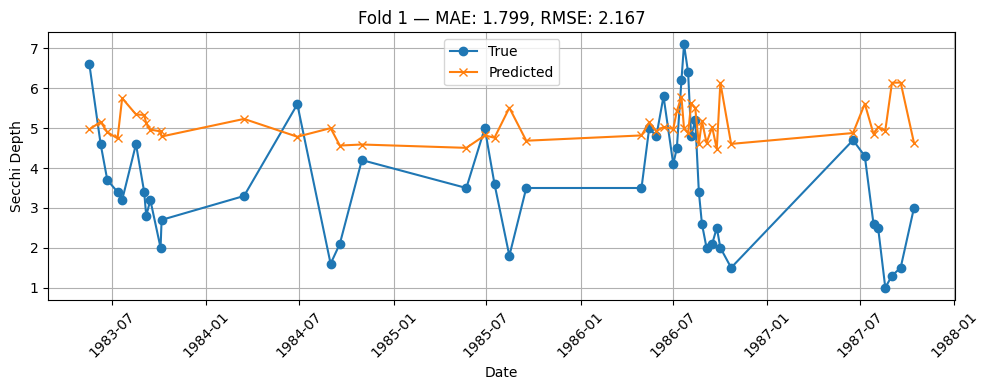

Fold 2: train = 75 | test = 48


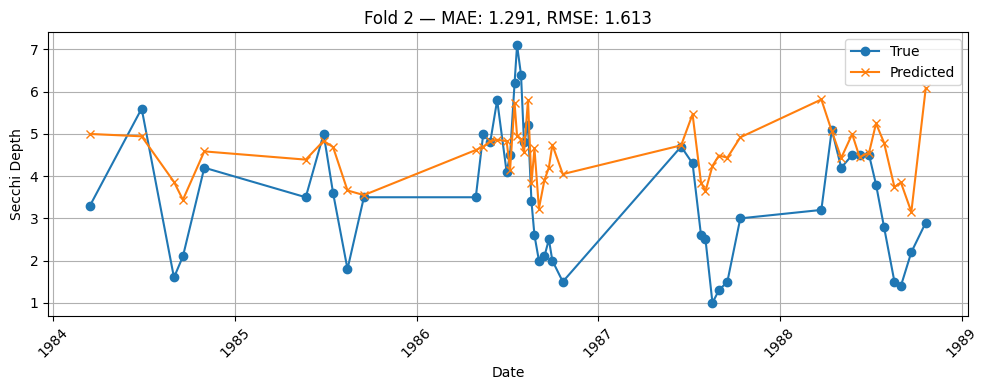

Fold 3: train = 80 | test = 57


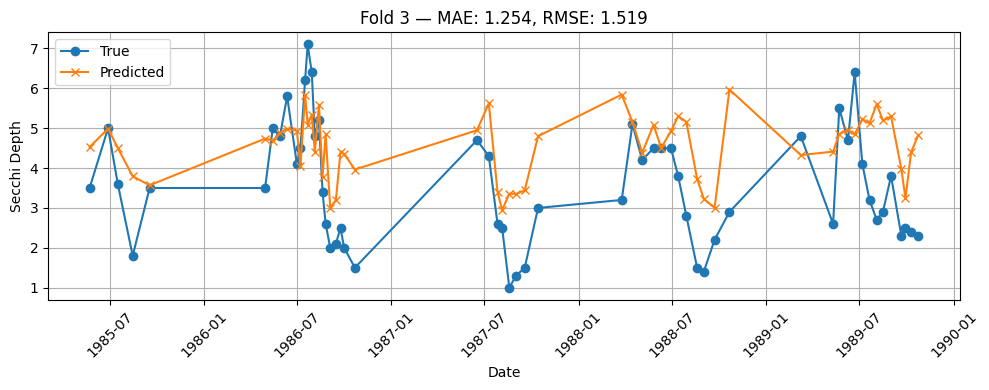

Fold 4: train = 85 | test = 61


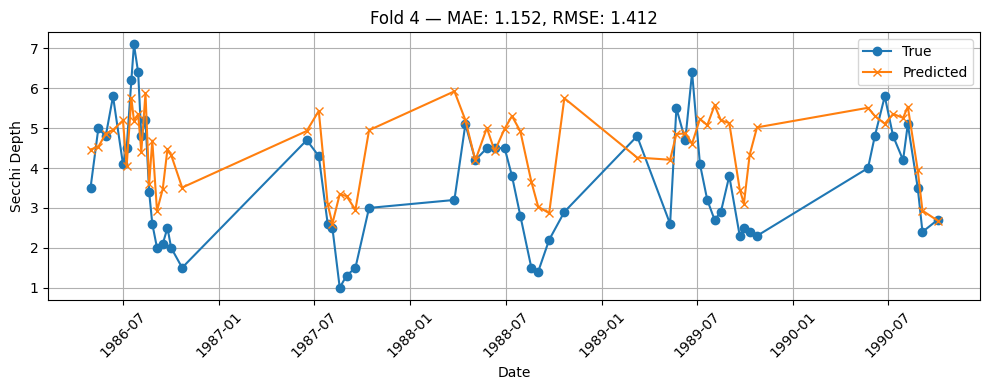

Fold 5: train = 103 | test = 51


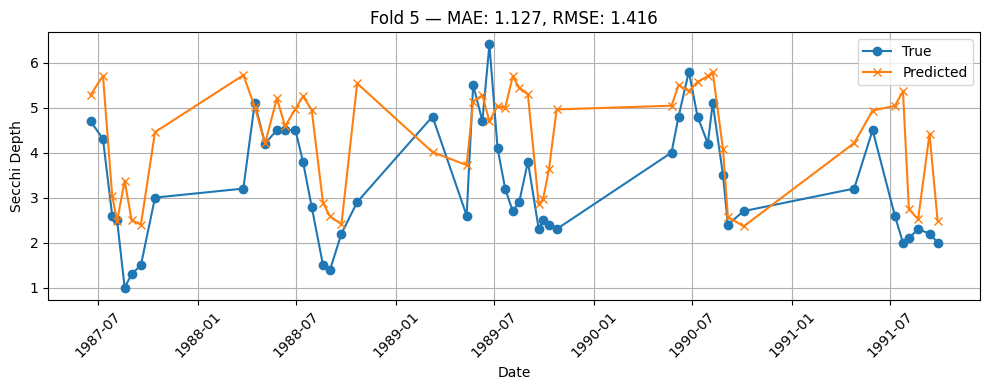

Fold 6: train = 111 | test = 54


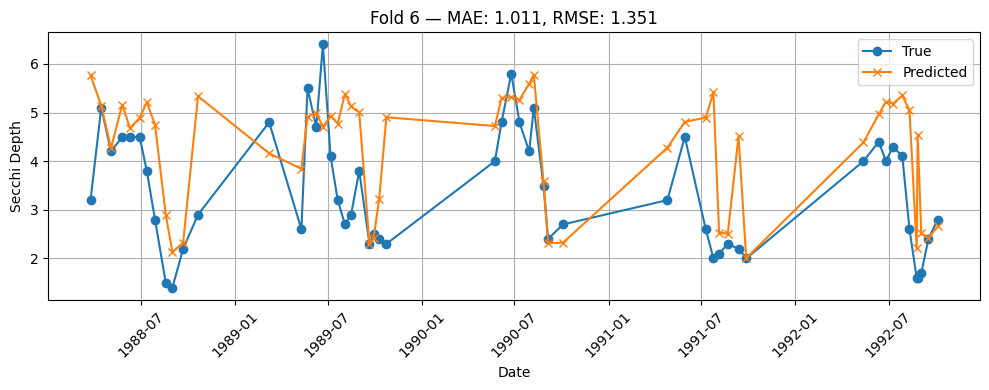

Fold 7: train = 123 | test = 61


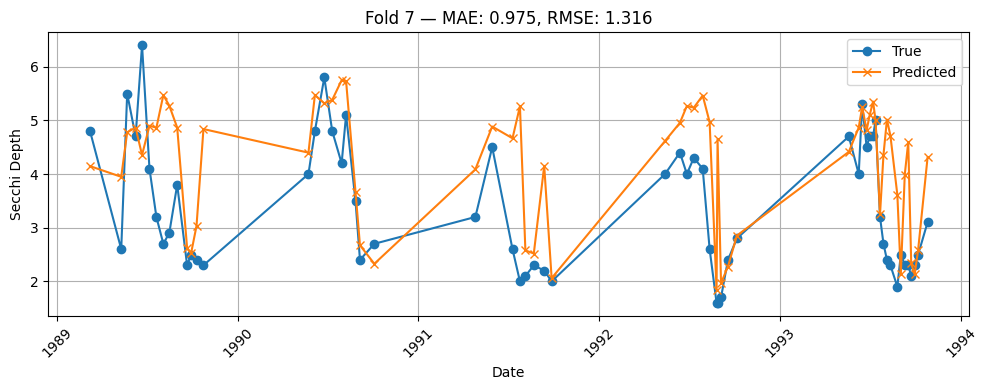

Fold 8: train = 137 | test = 57


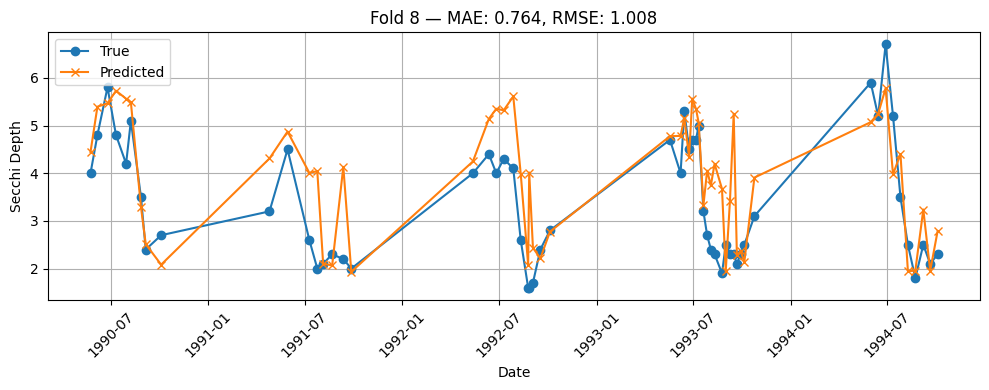

Fold 9: train = 146 | test = 58


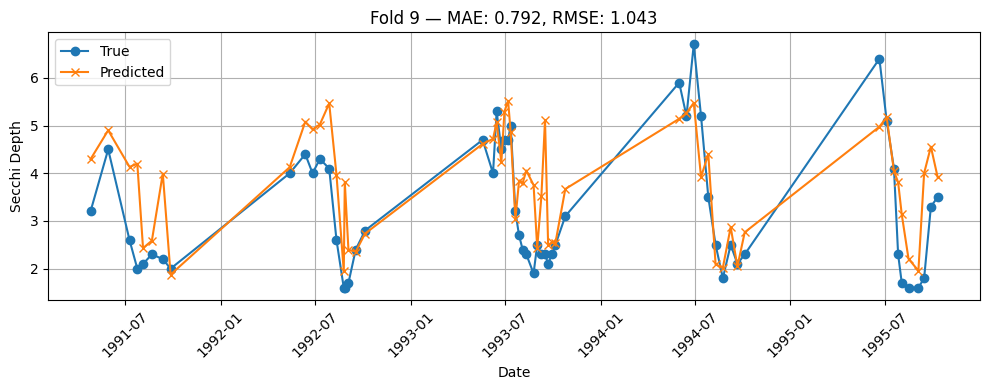

Fold 10: train = 154 | test = 60


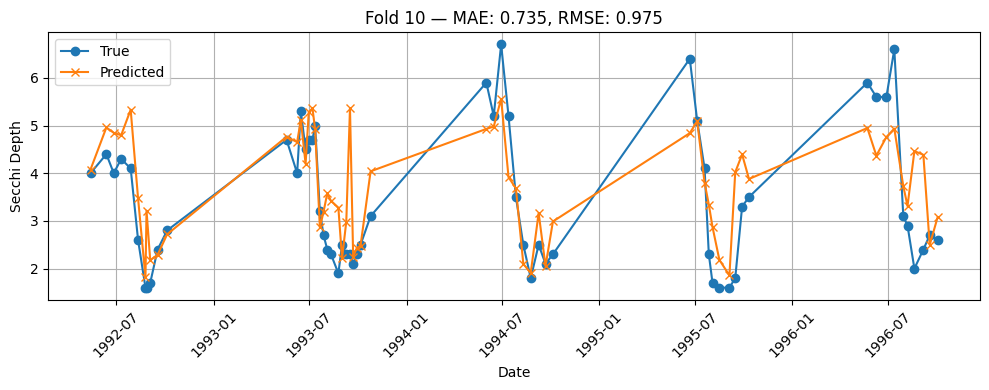

Fold 11: train = 165 | test = 70


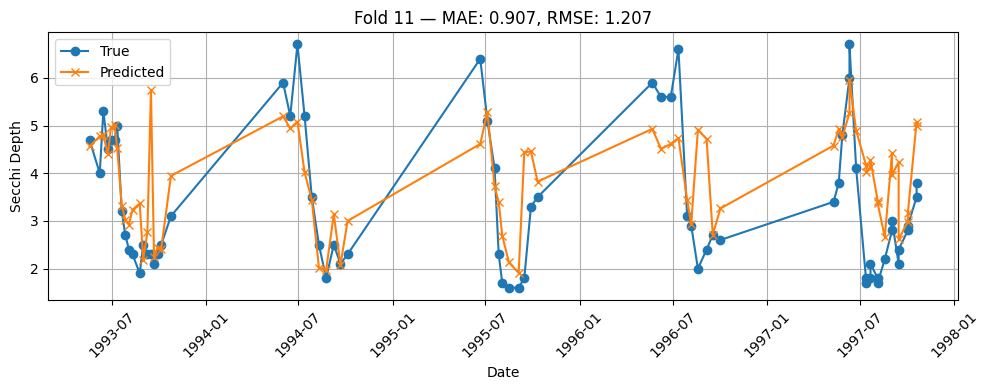

Fold 12: train = 184 | test = 84


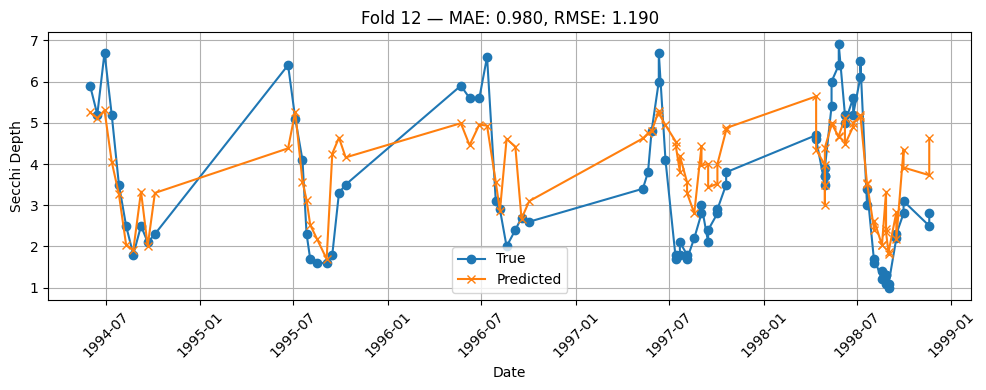

Fold 13: train = 194 | test = 84


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-15-1757171338.py", line 15, in <cell line: 0>
    results = forecast_secchi_per_lake(
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-13-1638790482.py", line 119, in forecast_secchi_per_lake
    plt.show()
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

In [ ]:

features = ['SECCBOT', 'TMAX', 'TMIN', 'DOMAX', 'DOMIN', 'MLD', 'OXIC', 'SCHMIDT', 'TPEC', 'TPBG', 'CHLA', 'PH', 'COLOR', 'CONDUCT', 'ALK']  # customize

from sklearn.preprocessing import LabelEncoder

for midas_id, lake_df in imputed_by_lake.items():
    print(f"Processing MIDAS: {midas_id}")

    # Convert string columns to numeric using LabelEncoder
    for col in features:
        if lake_df[col].dtype == 'object':
            le = LabelEncoder()
            lake_df[col] = le.fit_transform(lake_df[col].astype(str))

    # Now safe to call forecasting function, not using past secchi
    results = forecast_secchi_per_lake(
        df_lake=lake_df,
        features=features,
        use_past_secchi=False,
        model_name='rf',
        use_year_split=True,
        plot=True
    )

    print(f"Results for {midas_id}: {results}")

In [ ]:
for midas_id, lake_df in imputed_by_lake.items():
    print(f"Processing MIDAS: {midas_id}")

    # Convert string columns to numeric using LabelEncoder
    for col in features:
        if lake_df[col].dtype == 'object':
            le = LabelEncoder()
            lake_df[col] = le.fit_transform(lake_df[col].astype(str))

    # Now safe to call forecasting function
    results = forecast_secchi_per_lake(
        df_lake=lake_df,
        features=features,
        use_past_secchi=True,
        model_name='rf',
        use_year_split=True,
        plot=True
    )

    print(f"Results for {midas_id}: {results}")

# Visualizing Time Series

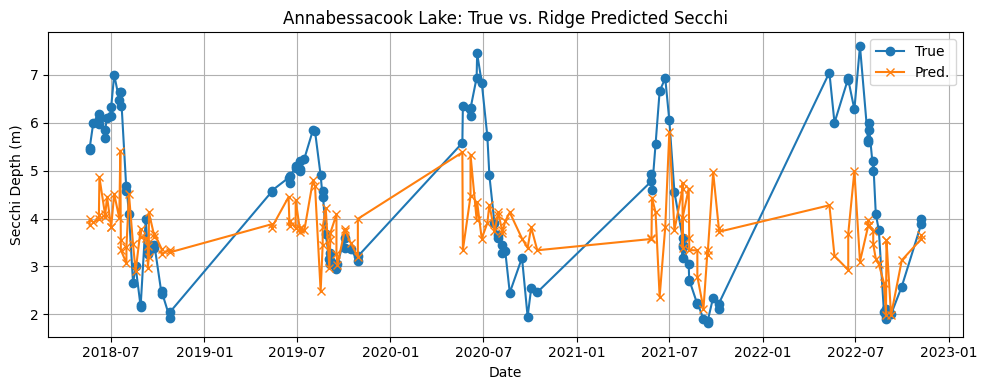

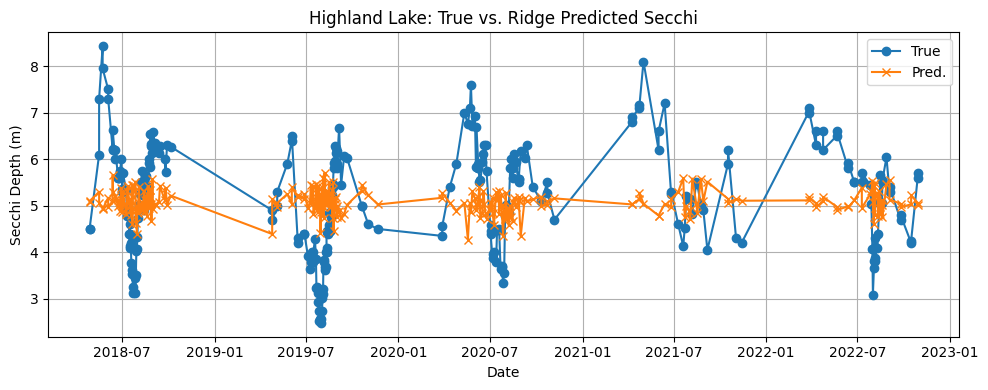

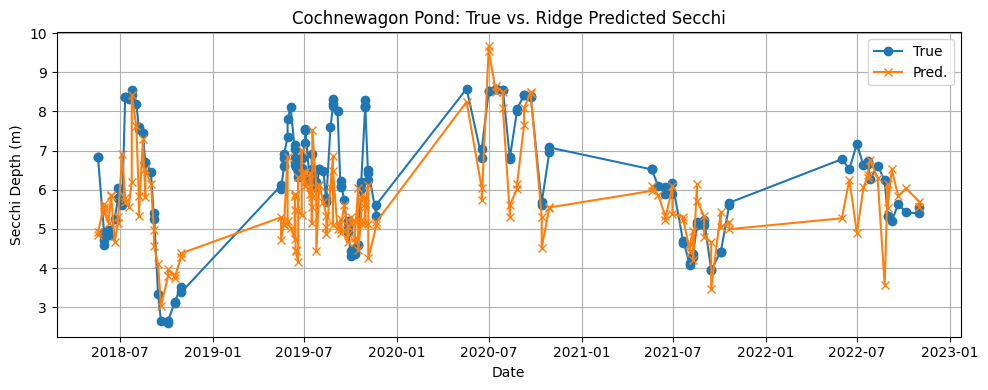

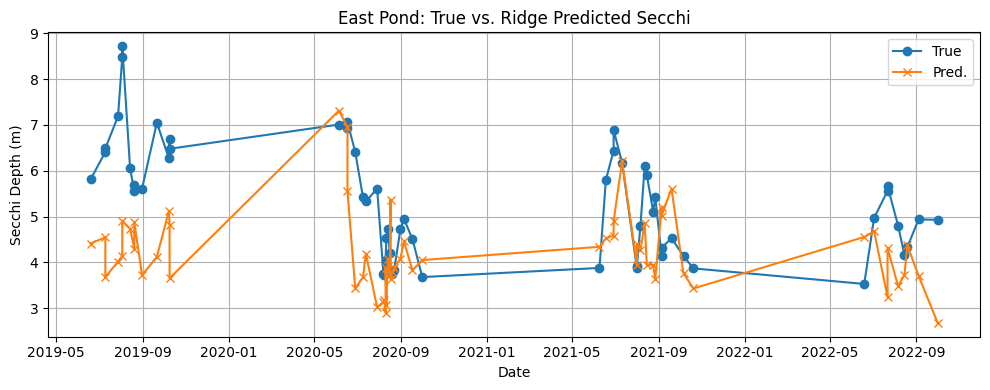

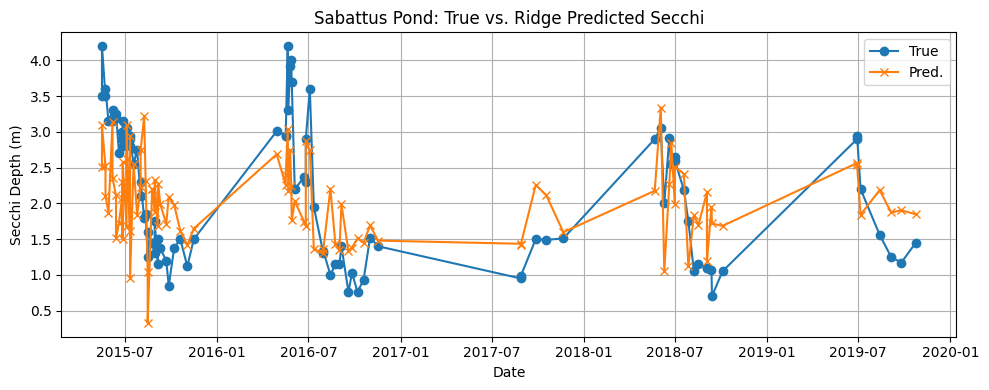

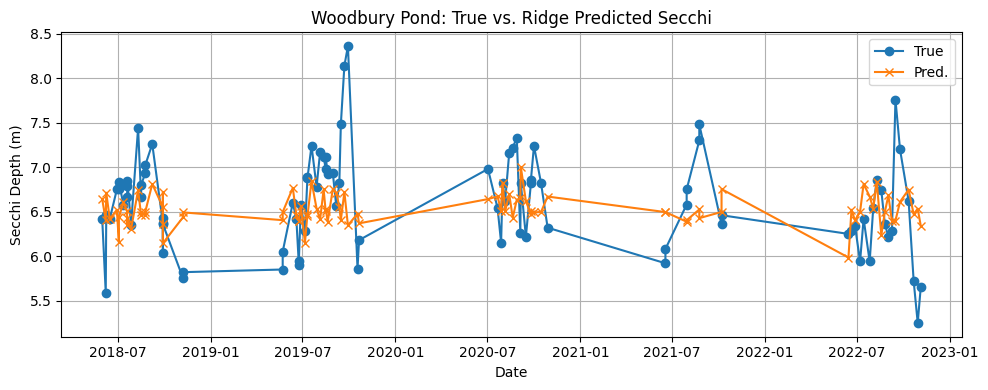

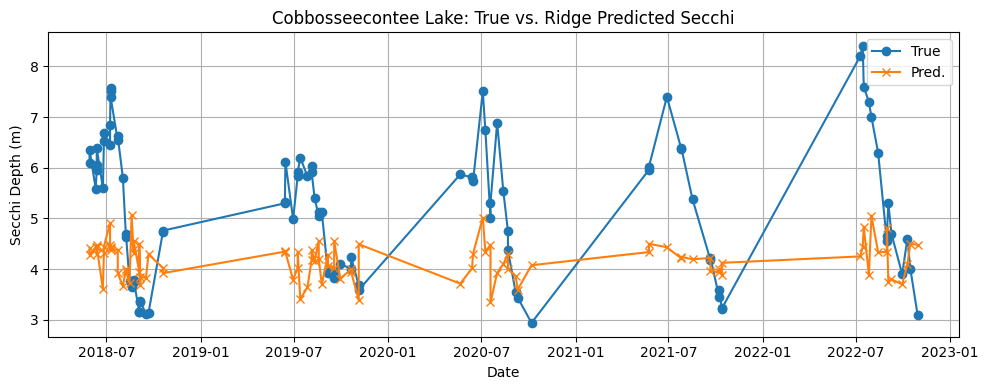

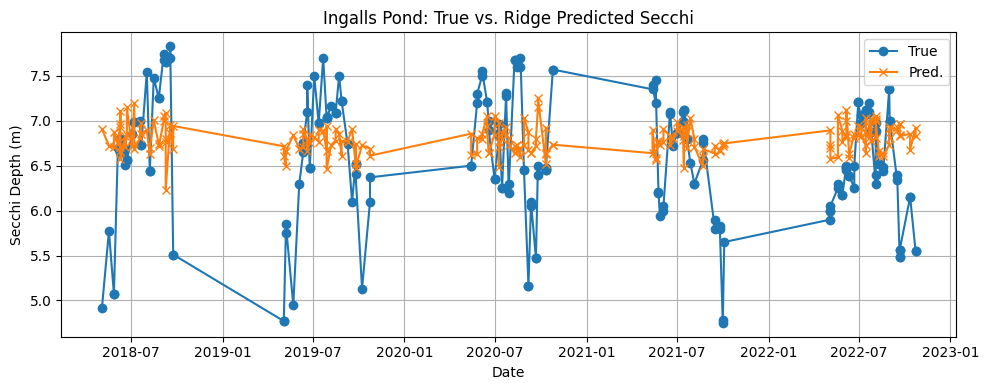

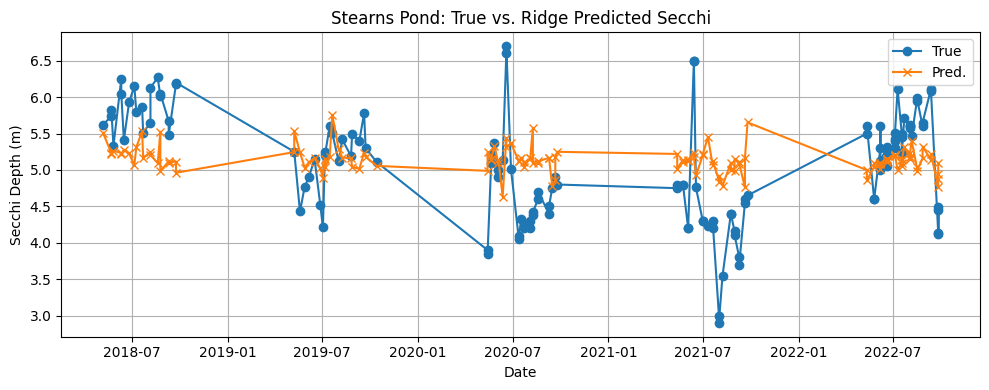

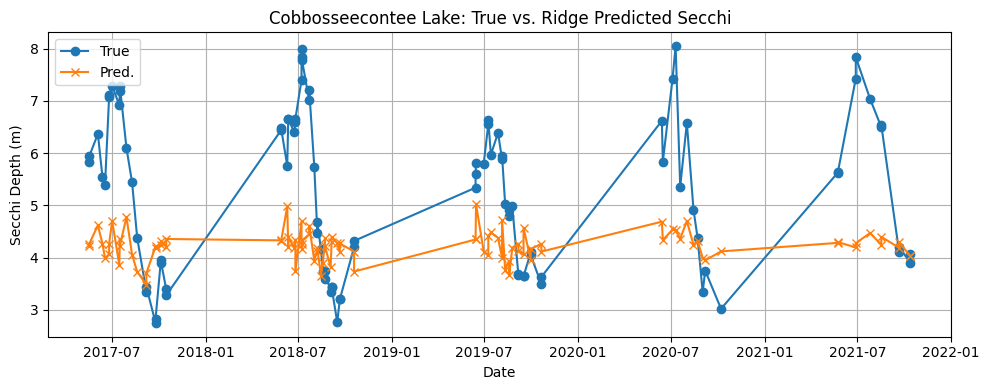

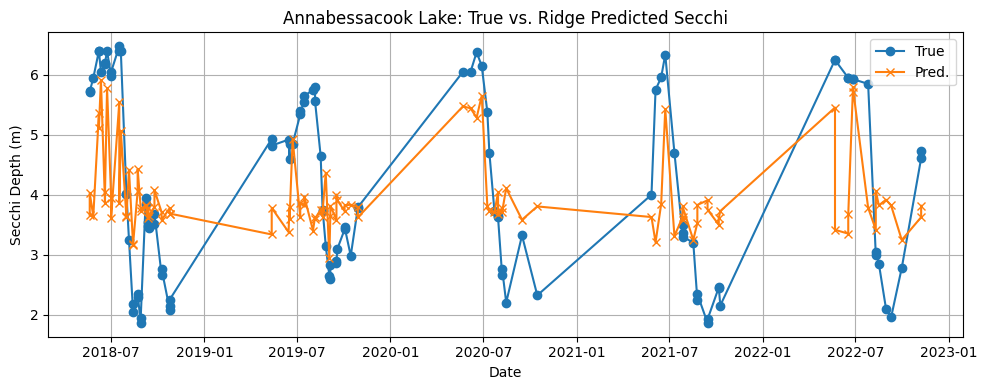

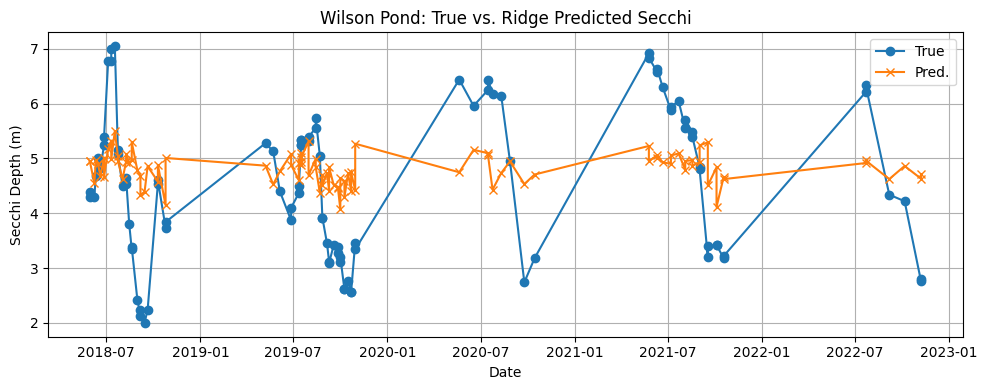

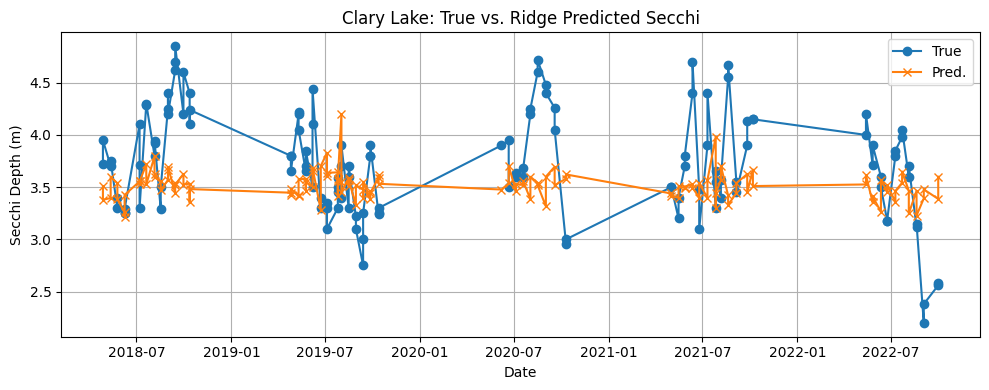

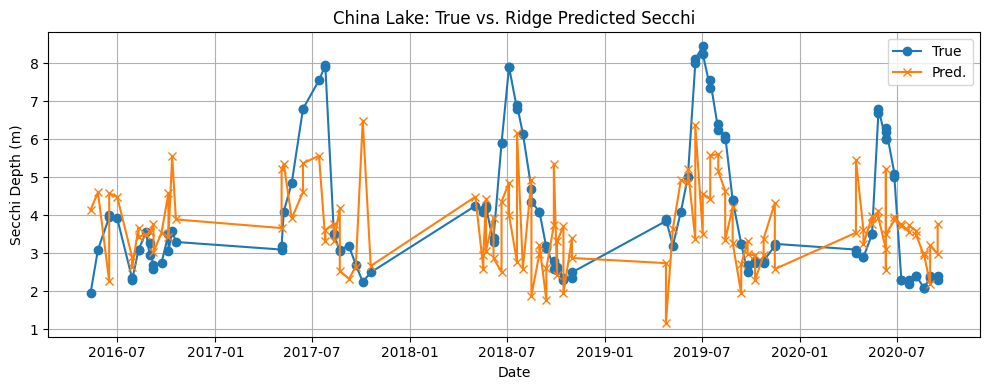

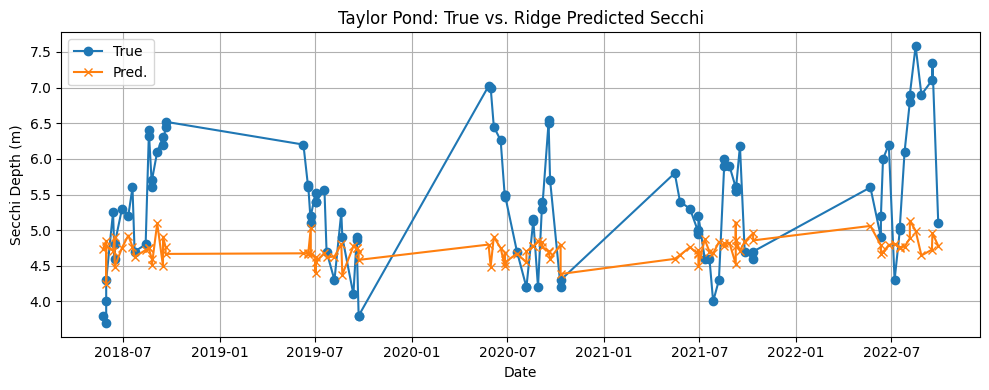

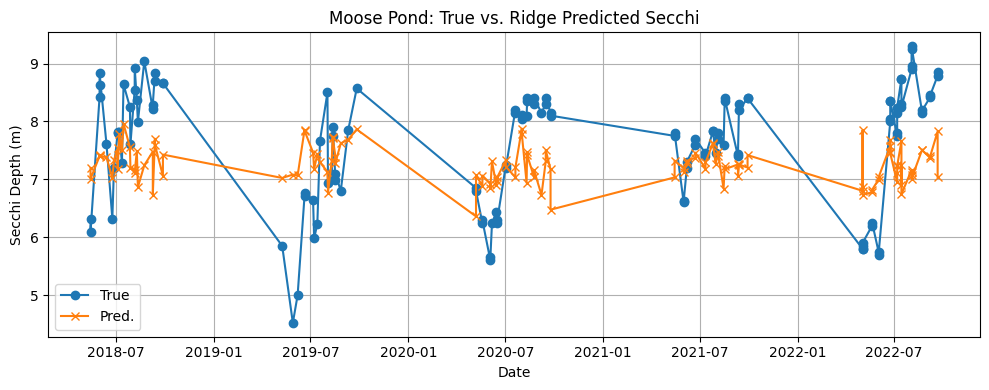

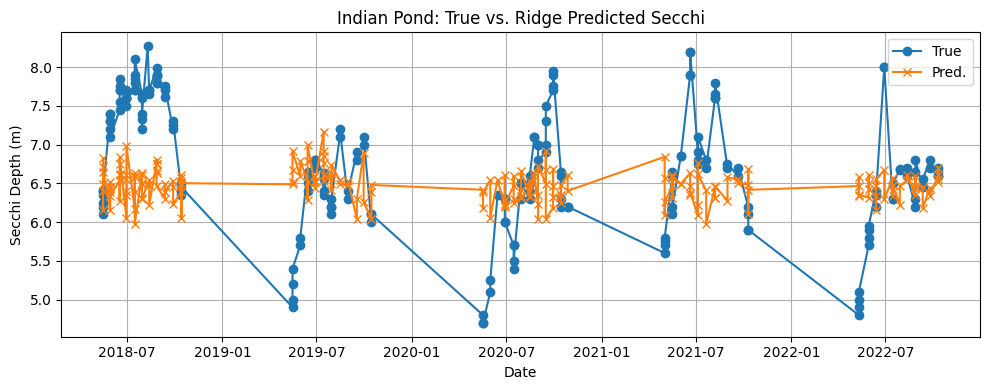

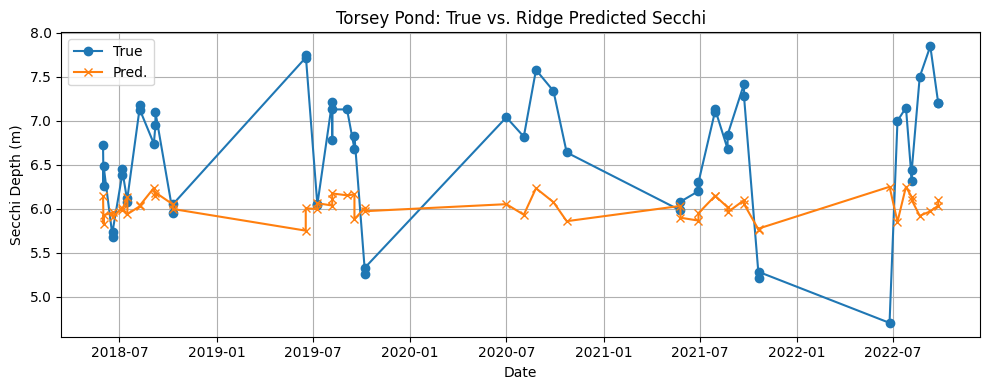

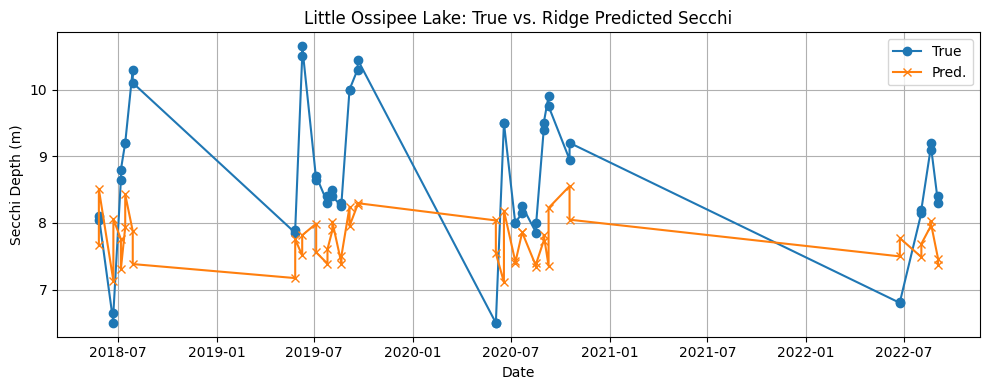

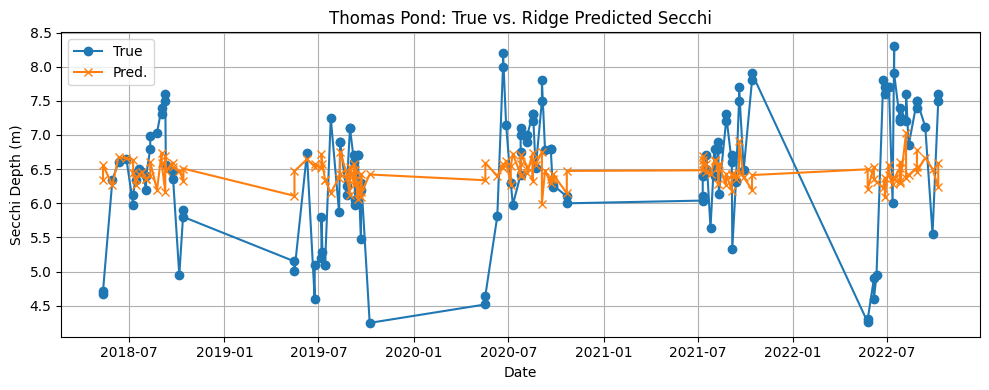

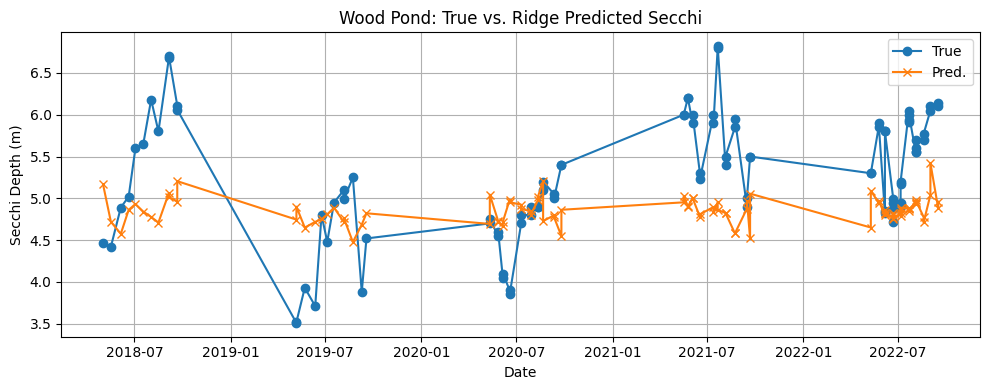

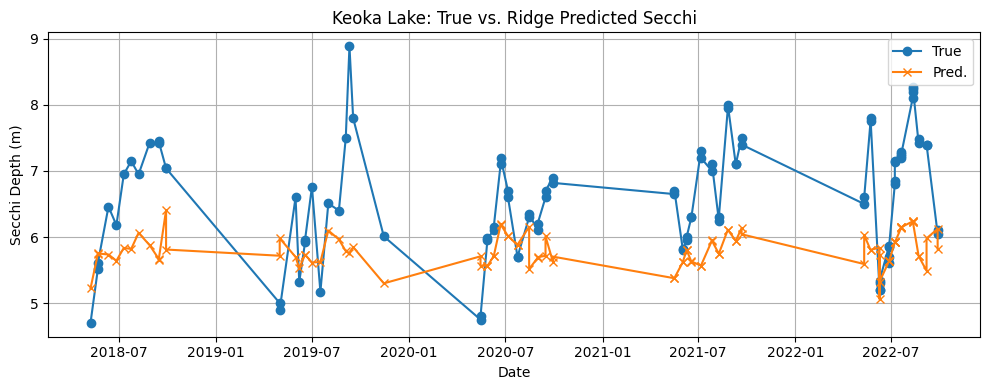

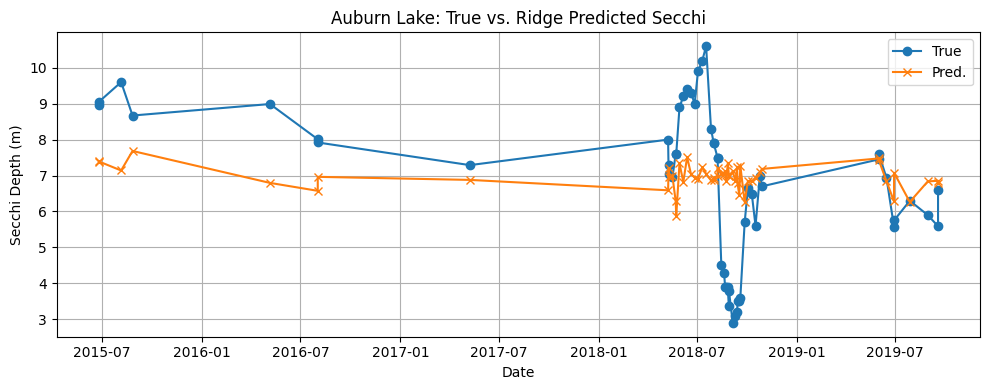

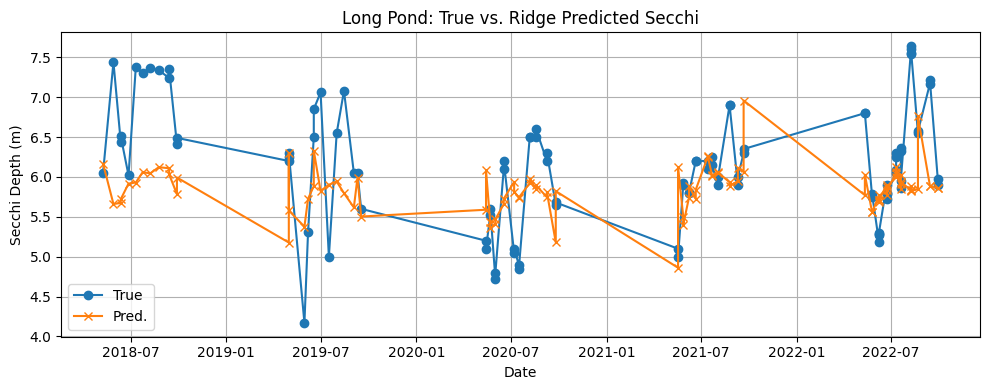

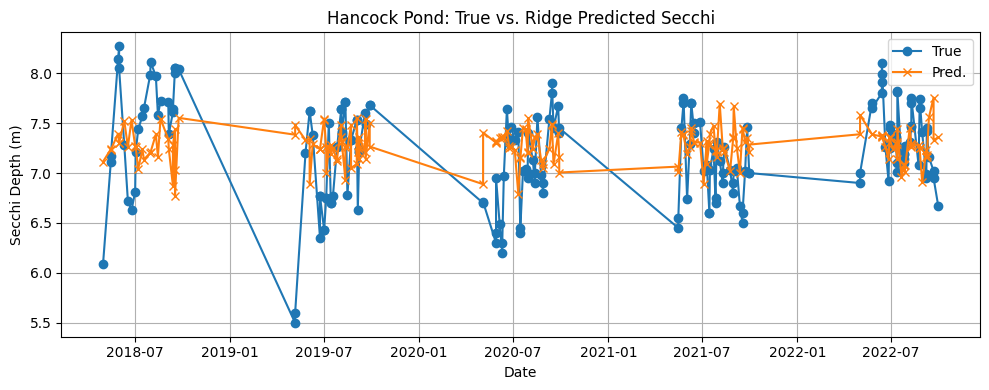

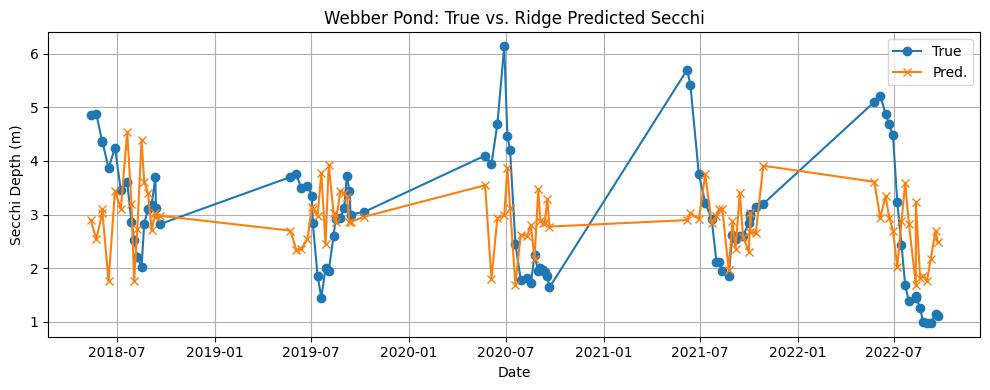

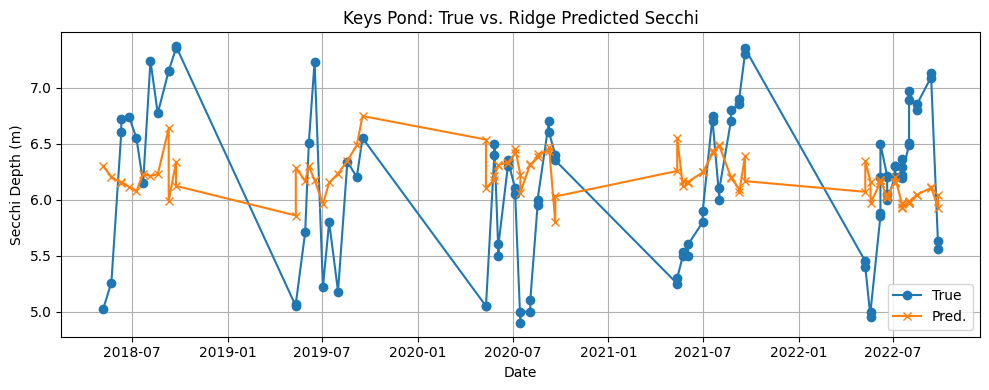

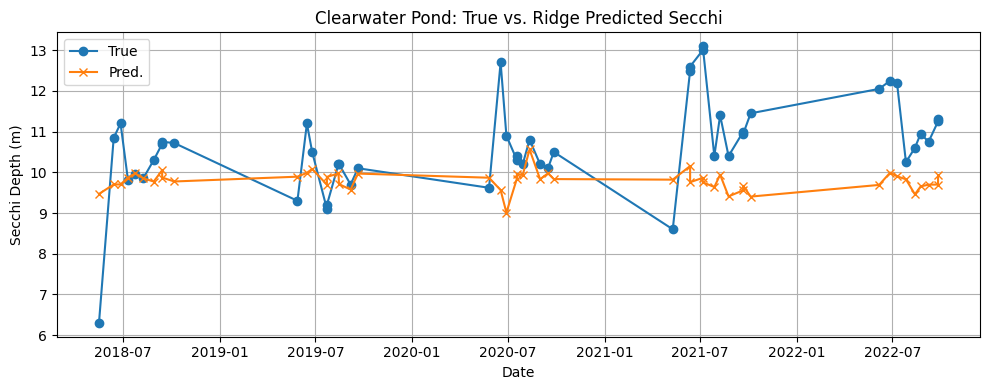

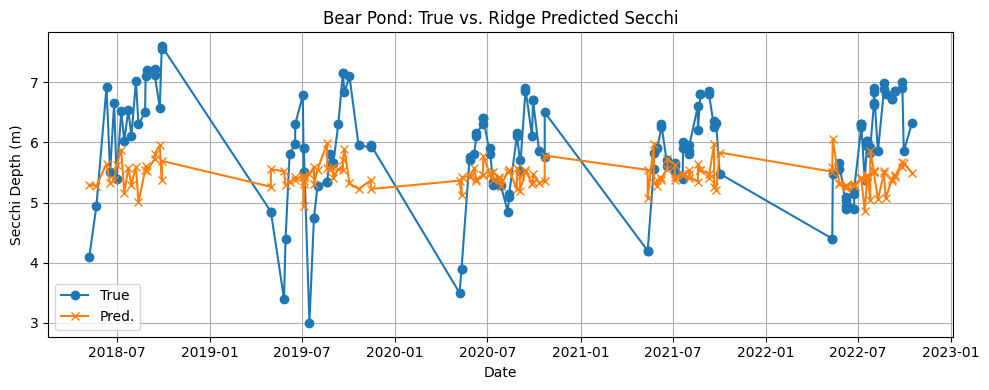

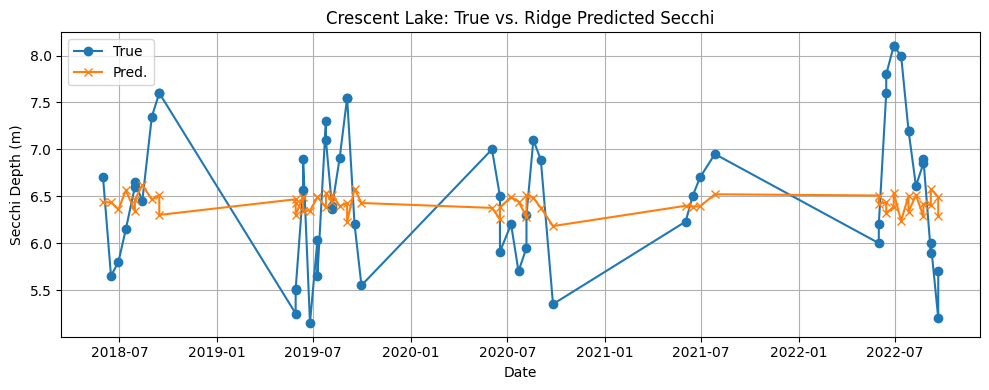

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1) Load auxiliary lake‐level max depths
depth_df = pd.read_excel(
    '/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy Computed_Data_clean_for lake names.xlsx'
)
depth_map = depth_df.groupby('modified_midas')['Depth'].max().to_dict()

# 2) Load raw Secchi data
raw_df = pd.read_excel(
    '/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy of SecchiDataDJW.xlsx',
    sheet_name='data', engine='openpyxl'
)

# 3) Preprocess flags & timestamps
raw_df['SECCBOT'] = raw_df['SECCBOT'].map({'Y': 1, 'N': 0})
raw_df['SAMPDATE'] = pd.to_datetime(raw_df['SAMPDATE'], utc=True)

# 4) Derive lake‐level ID & map depths, drop lakes w/o a depth
raw_df['modified_midas'] = raw_df['MIDAS'].astype(str).str.split('-', n=1).str[0]
raw_df['LAKE_DEPTH']     = raw_df['modified_midas'].map(depth_map)
raw_df = raw_df.dropna(subset=['LAKE_DEPTH'])

# 5) Load lake‐name lookup
class_df = pd.read_csv(
    '/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy of Class_Final_LakeNames.csv'
)
class_df['MIDAS_code'] = class_df['MIDAS'].astype(str).str.zfill(4)
name_map = dict(zip(class_df['MIDAS_code'], class_df['LakeName'].str.title()))

def midas_to_name(midas_id):
    code = midas_id.lstrip('c').split('-')[0].zfill(4)
    return name_map.get(code, midas_id)

# 6) Imputation helper (MICE)
def impute_data(df, midas_list, random_state=42):
    df_clean = df.replace(['NA','Na','N/A','--','?','N',pd.NA], np.nan)
    imp = IterativeImputer(random_state=random_state, max_iter=10, sample_posterior=True)
    out = {}
    for midas in midas_list:
        sub = df_clean[df_clean['MIDAS']==midas].copy()
        nums = sub.drop(columns=['MIDAS','SAMPDATE'], errors='ignore')
        nums = nums.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
        if nums.shape[1]==0:
            continue
        arr = imp.fit_transform(nums)
        sub[nums.columns] = arr
        out[midas] = sub
    return out

# pick your top-30:
top30 = raw_df['MIDAS'].value_counts().index[:30].tolist()
imputed_by_lake = impute_data(raw_df, top30)

# 7) Features + model
features = [
    'SECCBOT','TMAX','TMIN','DOMAX','DOMIN',
    'MLD','OXIC','SCHMIDT','TPEC','TPBG',
    'CHLA','PH','COLOR','CONDUCT','ALK'
]
model = Ridge()

# 8) Plot True vs. Predicted Secchi for each lake (last 5 years test)
for midas, df_l in imputed_by_lake.items():
    df2 = df_l.copy()
    df2['SAMPDATE'] = pd.to_datetime(df2['SAMPDATE'])
    df2 = df2.sort_values('SAMPDATE').reset_index(drop=True)
    df2['year'] = df2['SAMPDATE'].dt.year

    max_y = df2['year'].max()
    test_mask = df2['year'].between(max_y-4, max_y)
    train_df = df2[~test_mask]
    test_df  = df2[test_mask]
    if test_df.empty or len(train_df) < len(features)+1:
        continue

    # build X/y
    X_tr = train_df[features].apply(
        lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
    ).values
    X_te = test_df[features].apply(
        lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
    ).values
    y_tr = train_df['SECCHI'].values
    y_te = test_df['SECCHI'].values

    # drop all‐NaN cols
    keep = ~np.isnan(X_tr).all(axis=0)
    X_tr, X_te = X_tr[:,keep], X_te[:,keep]

    # impute remaining NaNs
    imp2 = SimpleImputer(strategy='mean')
    X_tr = imp2.fit_transform(X_tr)
    X_te = imp2.transform(X_te)

    # train & predict
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # plot
    lake_name = midas_to_name(midas)
    plt.figure(figsize=(10,4))
    plt.plot(test_df['SAMPDATE'], y_te, label='True',  marker='o')
    plt.plot(test_df['SAMPDATE'], y_pred, label='Pred.', marker='x')
    plt.title(f'{lake_name}: True vs. Ridge Predicted Secchi')
    plt.xlabel('Date')
    plt.ylabel('Secchi Depth (m)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Minimal Number of Data Points

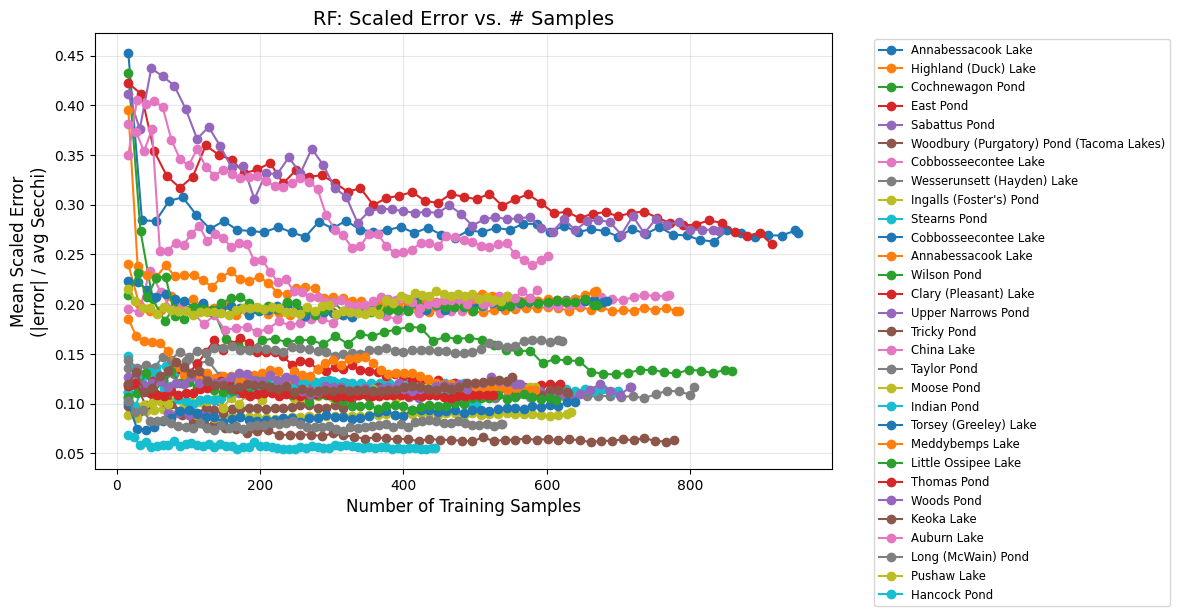

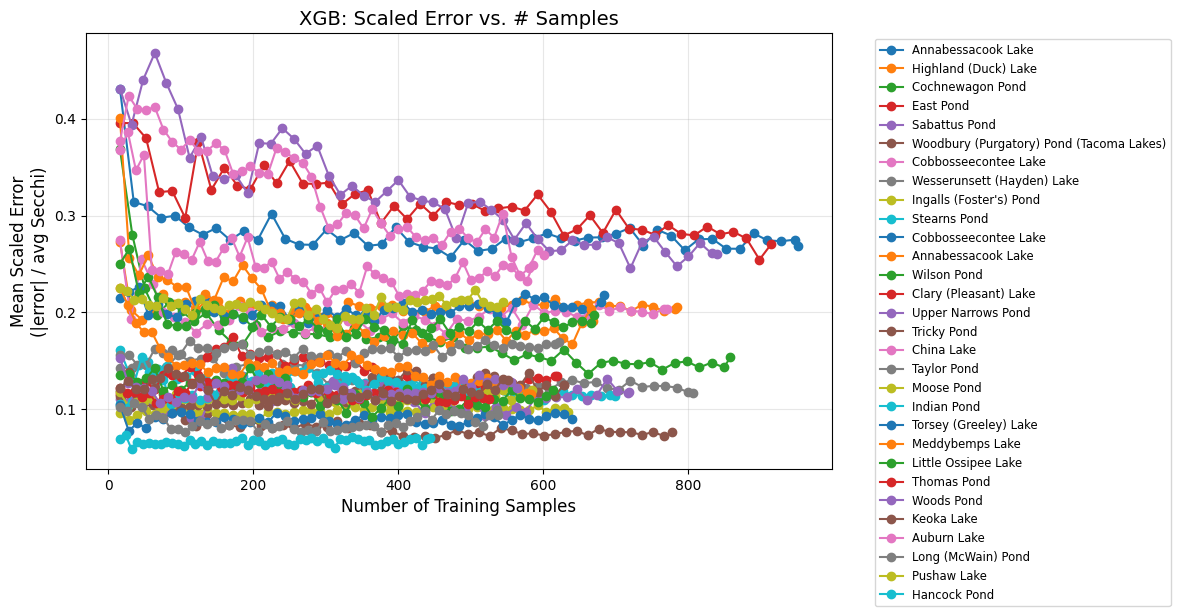

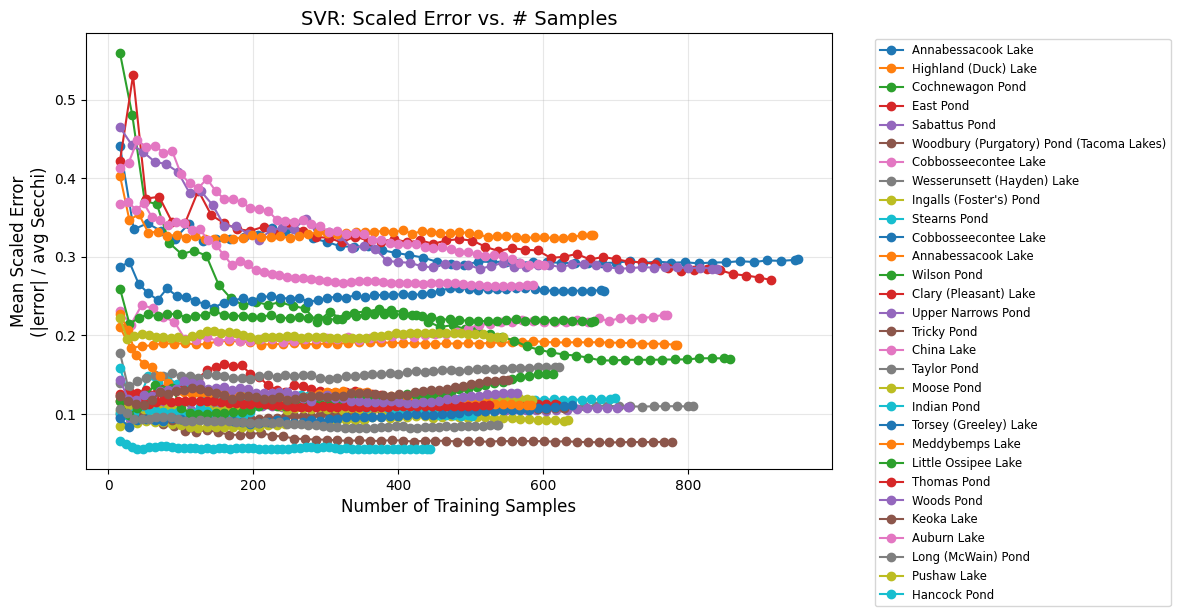

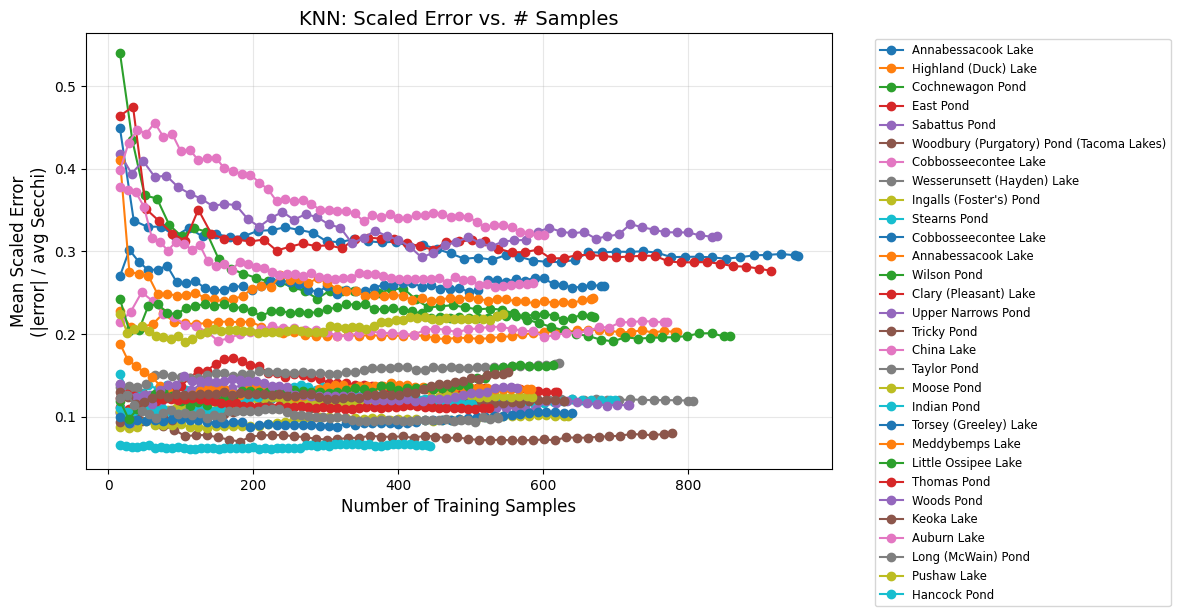

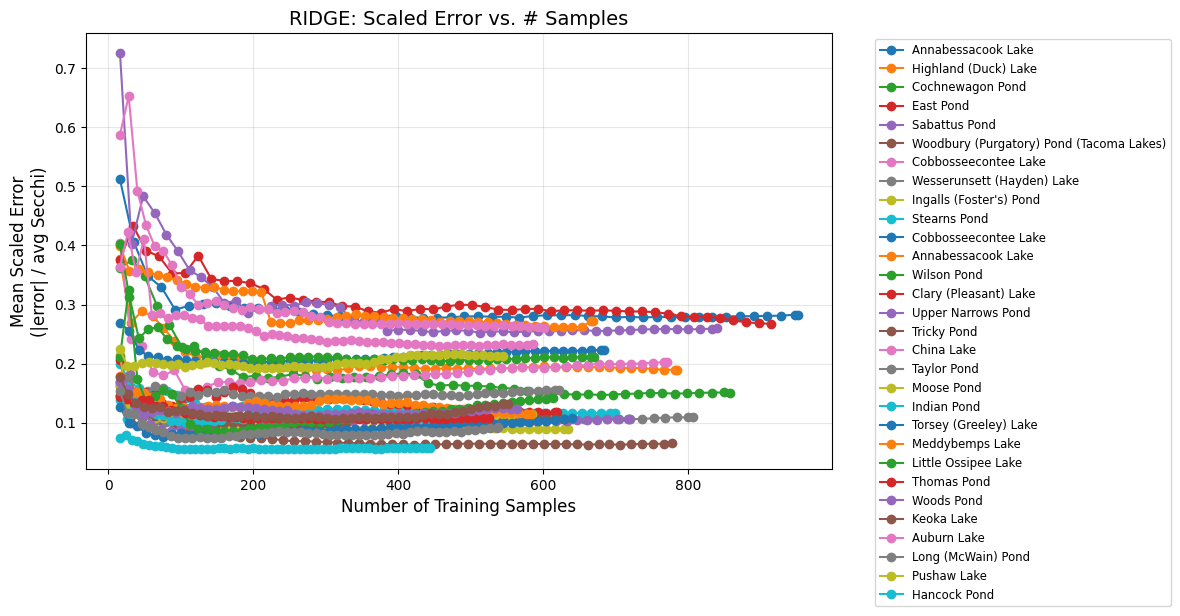

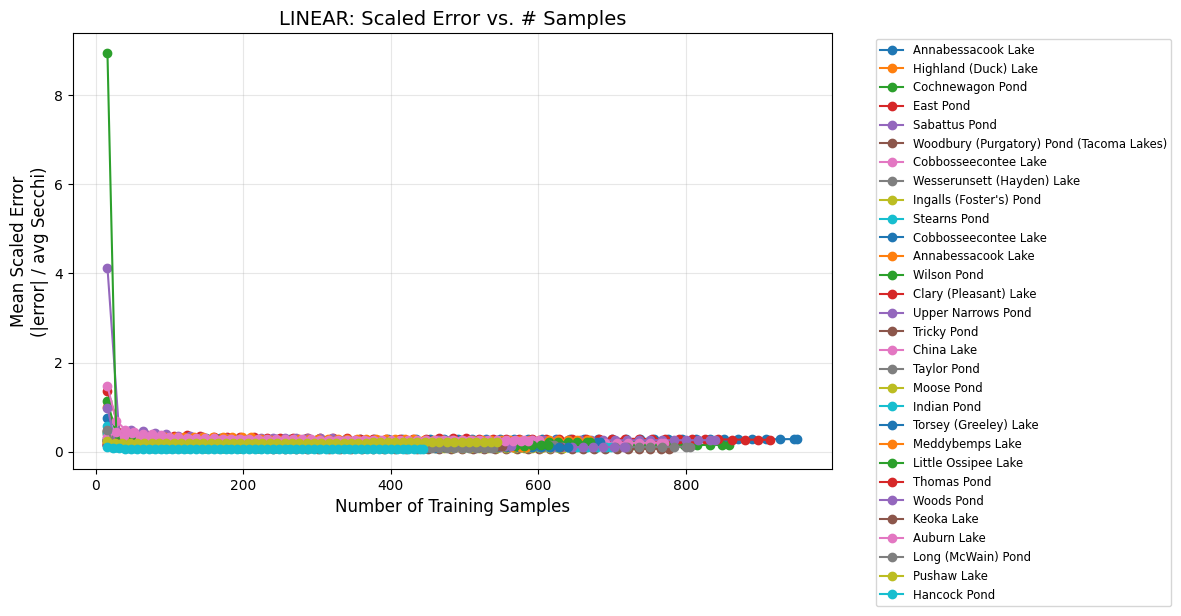

=== Final Scaled Errors by Lake ===
model                                          knn    linear        rf  \
midas                                                                    
Meddybemps Lake                           0.133694  0.115466  0.114180   
Hancock Pond                              0.064112  0.056724  0.055088   
Moose Pond                                0.123818  0.114018  0.116451   
Ingalls (Foster's) Pond                   0.100443  0.089048  0.091489   
Stearns Pond                              0.120174  0.116257  0.112403   
Tricky Pond                               0.119480  0.105926  0.110956   
Thomas Pond                               0.110487  0.108421  0.108927   
Keoka Lake                                0.154447  0.131887  0.127076   
Long (McWain) Pond                        0.098843  0.092913  0.079833   
Woods Pond                                0.134941  0.123230  0.119623   
Indian Pond                               0.115240  0.099517  0.099538   
Hi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# 1. Features
features = [
    'SECCBOT','TMAX','TMIN','DOMAX','DOMIN',
    'MLD','OXIC','SCHMIDT','TPEC','TPBG',
    'CHLA','PH','COLOR','CONDUCT','ALK'
]

# 2. Top-30 station IDs by raw count
df['MIDAS'] = df['MIDAS'].astype(str)
top30_stations = df['MIDAS'].value_counts().index[:30].tolist()

# 3. Load geography → lake name map, and helper fn
geo = pd.read_excel(
    "/content/drive/MyDrive/Colby Lake Research/Rishit MaineLakes_Geography_Morphometry.xls",
    sheet_name="DATA",
    engine="xlrd"
)
geo["MIDAS_code"] = geo["Lake Code (MIDAS)"].astype(str).str.zfill(4)
name_map = dict(zip(geo["MIDAS_code"], geo["Lake Name"]))

def midas_to_name(midas_id):
    code = midas_id.lstrip("c").split("-")[0].zfill(4)
    return name_map.get(code, midas_id)

# 4. Model constructors
model_constructors = {
    'rf':    lambda: RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1),
    'xgb':   lambda: XGBRegressor(n_estimators=50, max_depth=3, verbosity=0),
    'svr':   SVR,
    'knn':   KNeighborsRegressor,
    'ridge': Ridge,
    'linear': LinearRegression
}

# 5. Run experiment
summary_scaled = []
summary_samples = []

for model_name, Model in model_constructors.items():
    plt.figure(figsize=(12, 6))
    for midas in top30_stations:
        df_l = imputed_by_lake[midas].copy()
        df_l['SAMPDATE'] = pd.to_datetime(df_l['SAMPDATE'])
        df_l.sort_values('SAMPDATE', inplace=True)
        df_l['year'] = df_l['SAMPDATE'].dt.year

        max_y = df_l['year'].max()
        test_years = list(range(max_y-4, max_y+1))
        test_df = df_l[df_l['year'].isin(test_years)]
        if test_df.empty:
            continue

        y_test = test_df['SECCHI'].values
        mean_test = y_test.mean()

        pre_df = df_l[~df_l['year'].isin(test_years)]
        total_pre = len(pre_df)
        min_samps = len(features) + 1
        step = max(1, total_pre // 50)
        sample_ns = list(range(min_samps, total_pre+1, step))
        if sample_ns[-1] != total_pre:
            sample_ns.append(total_pre)

        scaled_means = []
        for n in sample_ns:
            train_df = pre_df.iloc[-n:]
            X_train = train_df[features].apply(
                lambda col: pd.factorize(col)[0] if col.dtype=='object' else col
            ).values
            X_test  = test_df[features].apply(
                lambda col: pd.factorize(col)[0] if col.dtype=='object' else col
            ).values
            y_train = train_df['SECCHI'].values

            valid = ~np.isnan(X_train).all(axis=0)
            X_train, X_test = X_train[:, valid], X_test[:, valid]

            imp = SimpleImputer(strategy='mean')
            X_train = imp.fit_transform(X_train)
            X_test  = imp.transform(X_test)

            model = Model()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scaled = np.abs(y_test - y_pred) / mean_test
            scaled_means.append(scaled.mean())

        if not scaled_means:
            continue

        df_res = pd.DataFrame({'n': sample_ns, 'scaled_err': scaled_means})
        name = midas_to_name(midas)
        plt.plot(df_res['n'], df_res['scaled_err'], marker='o', label=name)

        summary_scaled.append({
            'midas': midas,
            'model': model_name,
            'scaled_err_all': df_res['scaled_err'].iloc[-1]
        })

        baseline = df_res['scaled_err'].iloc[-1]
        threshold = baseline * 1.05
        candidates = df_res[df_res['scaled_err'] <= threshold]['n']
        plateau_n = candidates.min() if not candidates.empty else sample_ns[-1]
        summary_samples.append({
            'midas': midas,
            'model': model_name,
            'plateau_samples': plateau_n
        })

    plt.xlabel("Number of Training Samples", fontsize=12)
    plt.ylabel("Mean Scaled Error\n(|error| / avg Secchi)", fontsize=12)
    plt.title(f"{model_name.upper()}: Scaled Error vs. # Samples", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 6. Pivot and summarize
summary_df = pd.DataFrame(summary_scaled).pivot(index='midas', columns='model', values='scaled_err_all')
summary_samples_df = pd.DataFrame(summary_samples).pivot(index='midas', columns='model', values='plateau_samples')
avg_scaled  = summary_df.mean(axis=1)
min_samples = summary_samples_df.min(axis=1)
lake_summary = pd.DataFrame({'avg_scaled_error': avg_scaled, 'min_samples': min_samples})

# 7. Rename indices to lake names
summary_df_named      = summary_df.rename(index=midas_to_name)
summary_samples_named = summary_samples_df.rename(index=midas_to_name)
lake_summary_named    = lake_summary.rename(index=midas_to_name)

print("=== Final Scaled Errors by Lake ===")
print(summary_df_named, "\n")
print("=== Plateau Samples by Lake ===")
print(summary_samples_named, "\n")
print("=== Per-Lake Summary ===")
print(lake_summary_named)


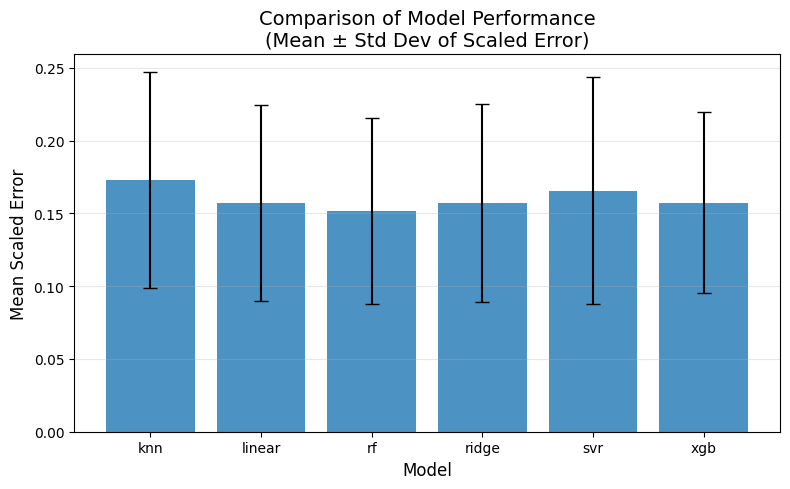

In [ ]:
import matplotlib.pyplot as plt

# Assume summary_df is your DataFrame indexed by MIDAS

# 1. Compute per-model mean and std
model_means = summary_df.mean(axis=0)
model_stds  = summary_df.std(axis=0)

# 2. Plot
plt.figure(figsize=(8,5))
bars = plt.bar(
    model_means.index,
    model_means.values,
    yerr=model_stds.values,
    capsize=5,
    alpha=0.8
)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Mean Scaled Error", fontsize=12)
plt.title("Comparison of Model Performance\n(Mean ± Std Dev of Scaled Error)", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

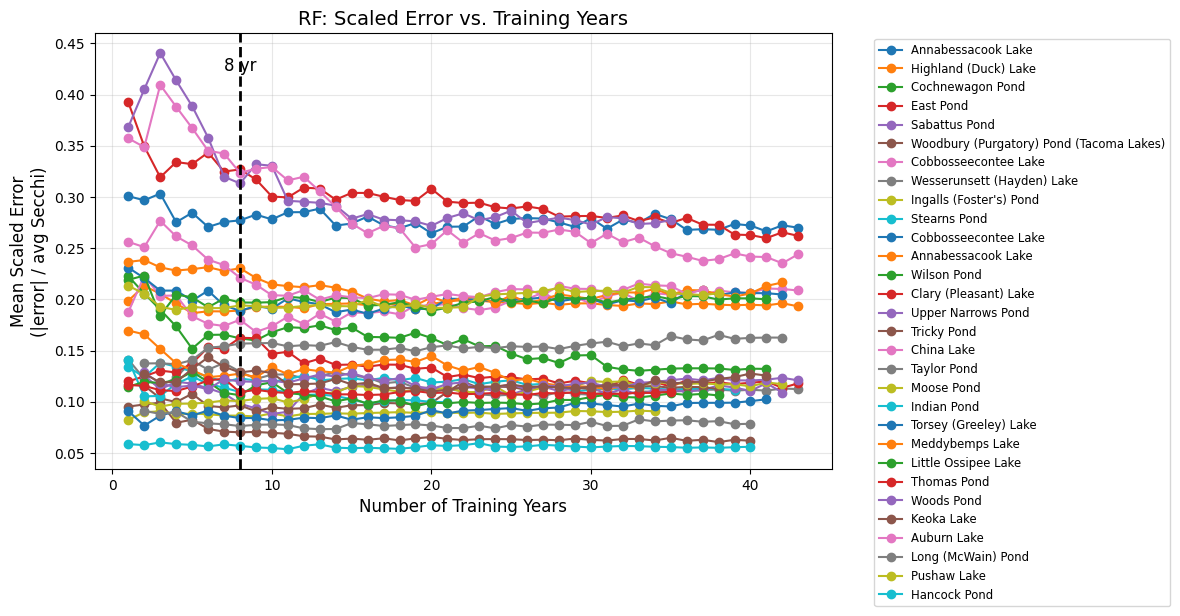

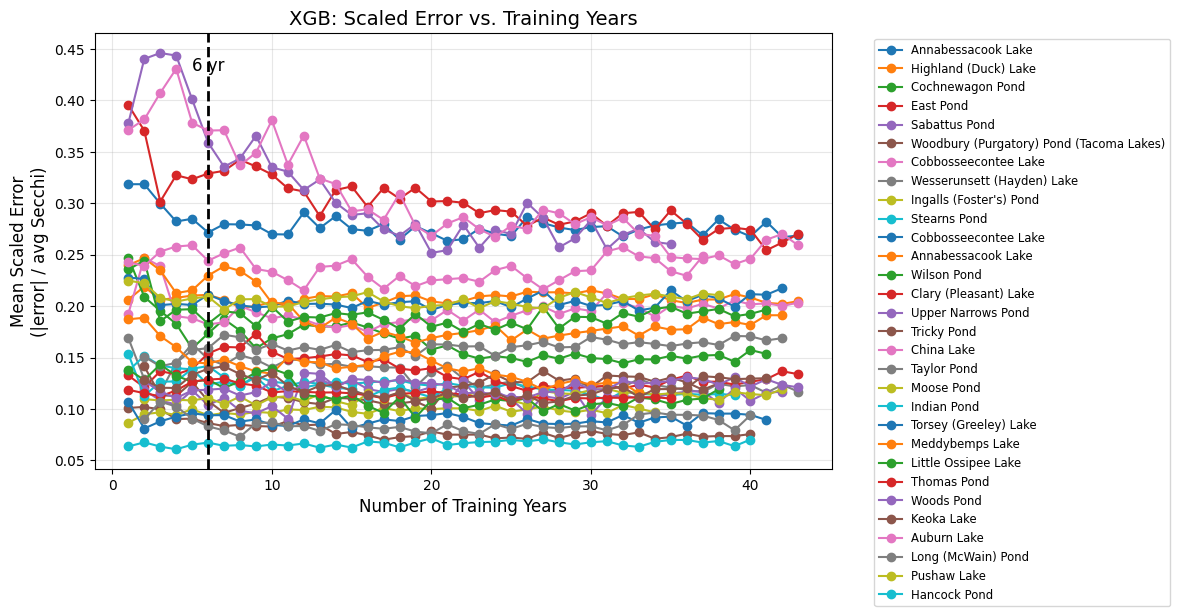

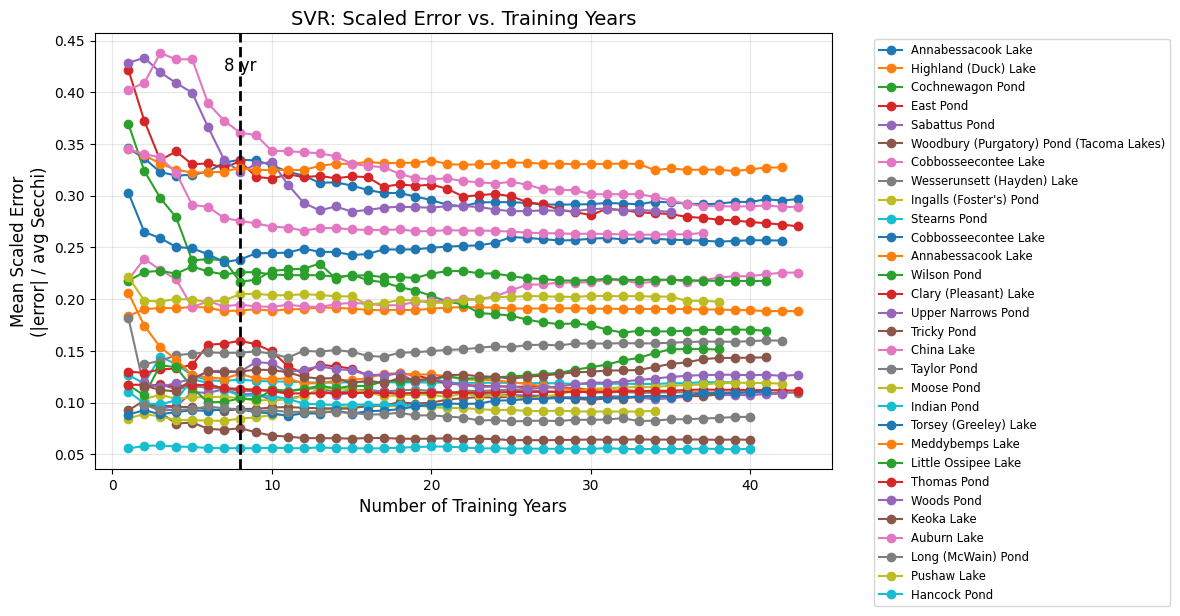

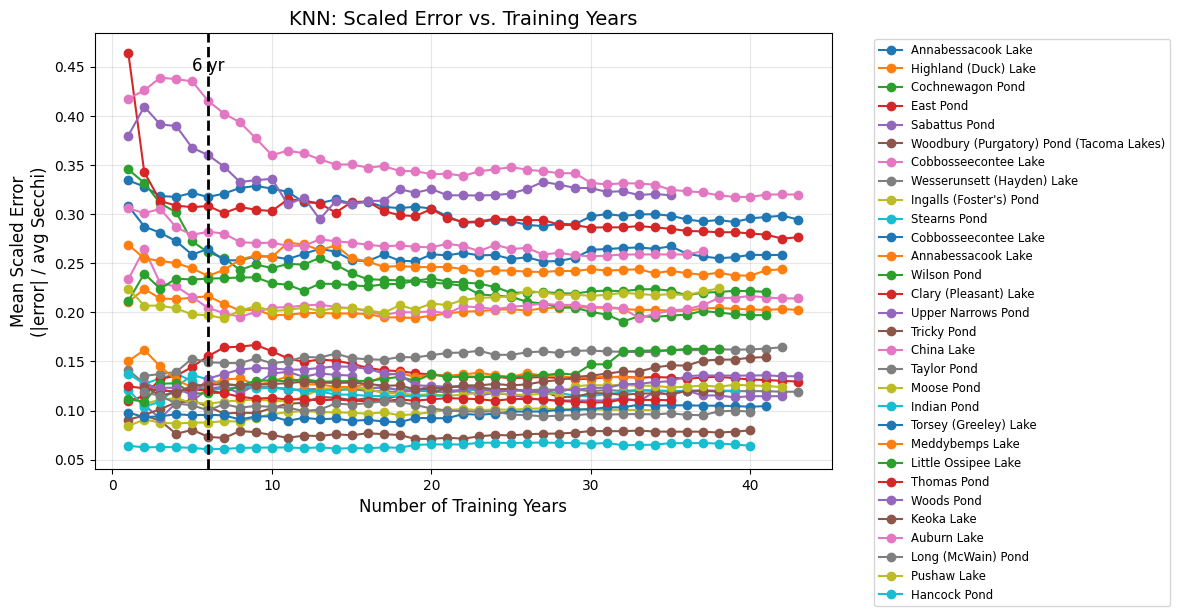

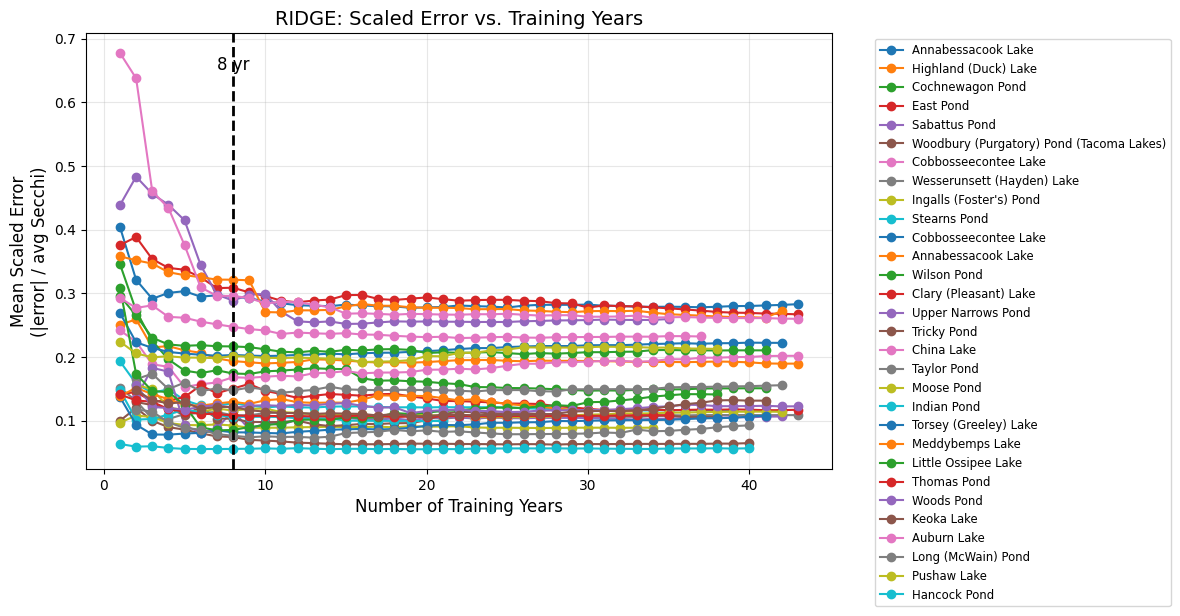

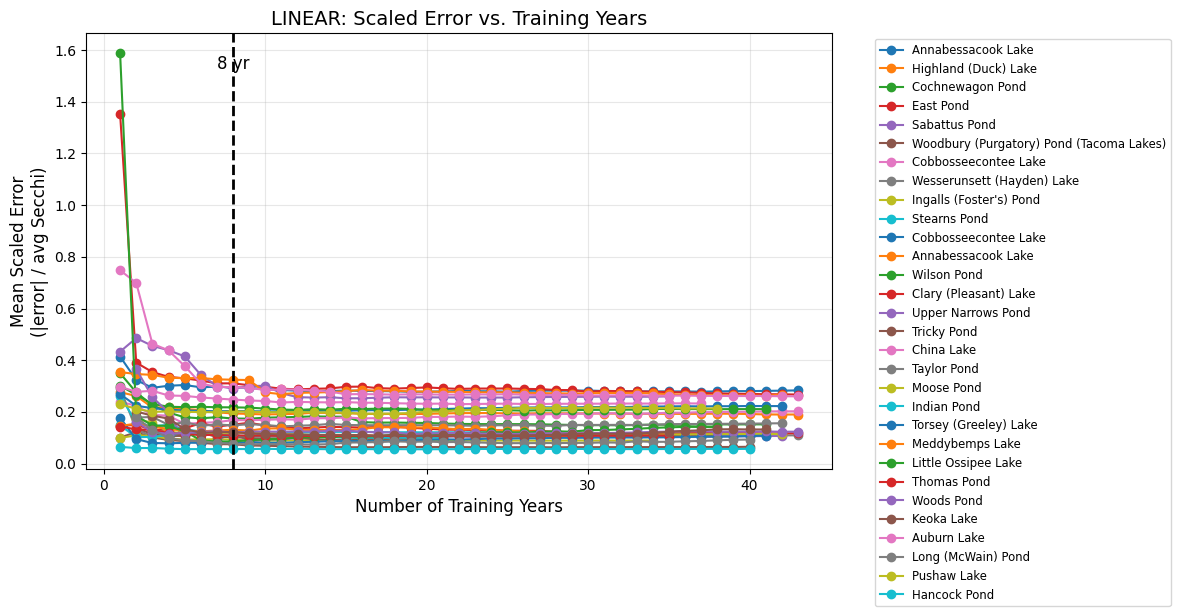

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# 1. Features
features = [
    'SECCBOT','TMAX','TMIN','DOMAX','DOMIN',
    'MLD','OXIC','SCHMIDT','TPEC','TPBG',
    'CHLA','PH','COLOR','CONDUCT','ALK'
]

# 2. Top-30 station IDs by raw count
df['MIDAS'] = df['MIDAS'].astype(str)
top30_stations = df['MIDAS'].value_counts().index[:30].tolist()

# 3. Load geography → lake name map, and helper fn
geo = pd.read_excel(
    "/content/drive/MyDrive/Colby Lake Research/Rishit MaineLakes_Geography_Morphometry.xls",
    sheet_name="DATA",
    engine="xlrd"
)
geo["MIDAS_code"] = geo["Lake Code (MIDAS)"].astype(str).str.zfill(4)
name_map = dict(zip(geo["MIDAS_code"], geo["Lake Name"]))

def midas_to_name(midas_id):
    code = midas_id.lstrip("c").split("-")[0].zfill(4)
    return name_map.get(code, midas_id)

# 4. Model constructors
models = {
    'rf':    lambda: RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1),
    'xgb':   lambda: XGBRegressor(n_estimators=50, max_depth=3, verbosity=0),
    'svr':   SVR,
    'knn':   KNeighborsRegressor,
    'ridge': Ridge,
    'linear':LinearRegression
}

# 5. Run experiment with black vertical line + annotation
for model_name, M in models.items():
    plt.figure(figsize=(12,6))
    plateau_years = []

    for midas in top30:
        df_l = imputed_by_lake[midas].copy()
        df_l['SAMPDATE'] = pd.to_datetime(df_l['SAMPDATE'])
        df_l.sort_values('SAMPDATE', inplace=True)
        df_l['year'] = df_l['SAMPDATE'].dt.year

        max_y = df_l['year'].max()
        test = df_l[df_l['year'].between(max_y-4, max_y)]
        if test.empty: continue
        y_test = test['SECCHI'].values
        mean_test = y_test.mean()

        pre = df_l[~df_l['year'].between(max_y-4, max_y)]
        years_avail = sorted(pre['year'].unique())
        errs = []
        for w in range(1, len(years_avail)+1):
            yrs = years_avail[-w:]
            train = pre[pre['year'].isin(yrs)]
            if len(train) < len(features)+1:
                errs.append(np.nan)
                continue

            X_tr = train[features].apply(
                lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
            ).values
            X_te = test[features].apply(
                lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
            ).values
            y_tr = train['SECCHI'].values

            valid = ~np.isnan(X_tr).all(axis=0)
            X_tr, X_te = X_tr[:,valid], X_te[:,valid]

            imp = SimpleImputer(strategy='mean')
            X_tr = imp.fit_transform(X_tr)
            X_te = imp.transform(X_te)

            mdl = M()
            mdl.fit(X_tr, y_tr)
            y_pred = mdl.predict(X_te)

            errs.append(np.abs(y_test - y_pred).mean() / mean_test)

        df_res = pd.DataFrame({
            'years': np.arange(1, len(years_avail)+1),
            'scaled_err': errs
        }).dropna()

        final = df_res['scaled_err'].iloc[-1]
        thresh = final * 1.05
        cand = df_res[df_res['scaled_err'] <= thresh]['years']
        pyear = int(cand.min() if not cand.empty else df_res['years'].max())
        plateau_years.append(pyear)

        plt.plot(df_res['years'], df_res['scaled_err'],
                 marker='o', label=midas_to_name(midas))

    # draw black vertical line at mean plateau and annotate
    mean_plateau = int(round(np.mean(plateau_years)))
    plt.axvline(mean_plateau, color='black', linestyle='--', linewidth=2)
    ymax = plt.ylim()[1]
    plt.text(mean_plateau, ymax*0.95, f"{mean_plateau} yr",
             color='black', ha='center', va='top', fontsize=12)

    plt.xlabel("Number of Training Years", fontsize=12)
    plt.ylabel("Mean Scaled Error\n(|error| / avg Secchi)", fontsize=12)
    plt.title(f"{model_name.upper()}: Scaled Error vs. Training Years", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Categorized Lake Data - Exp Repeat


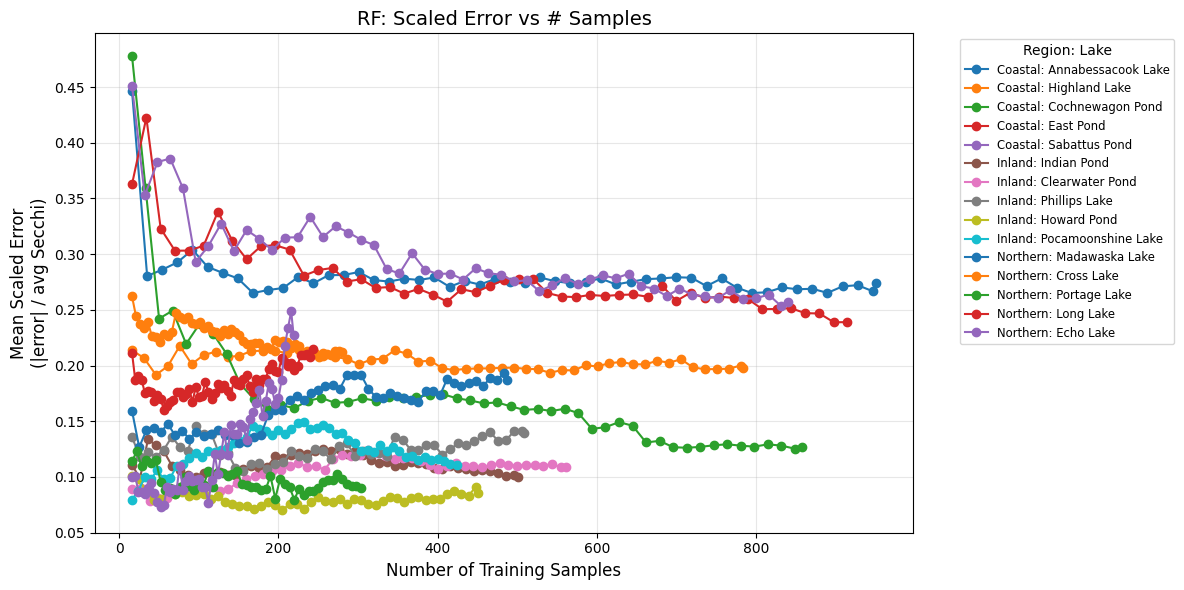

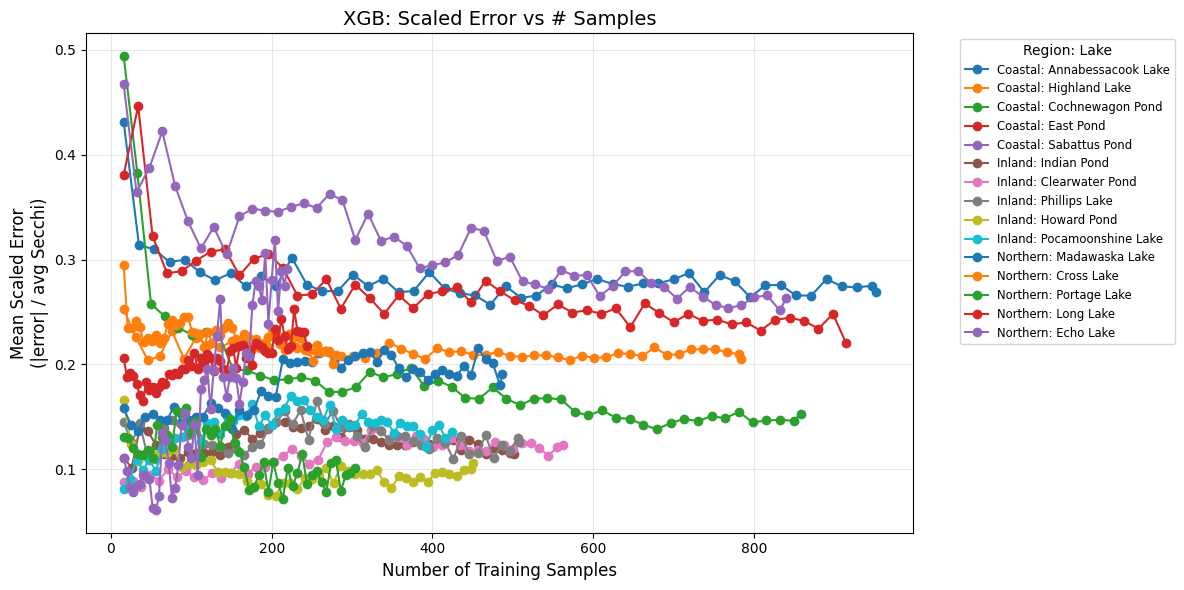

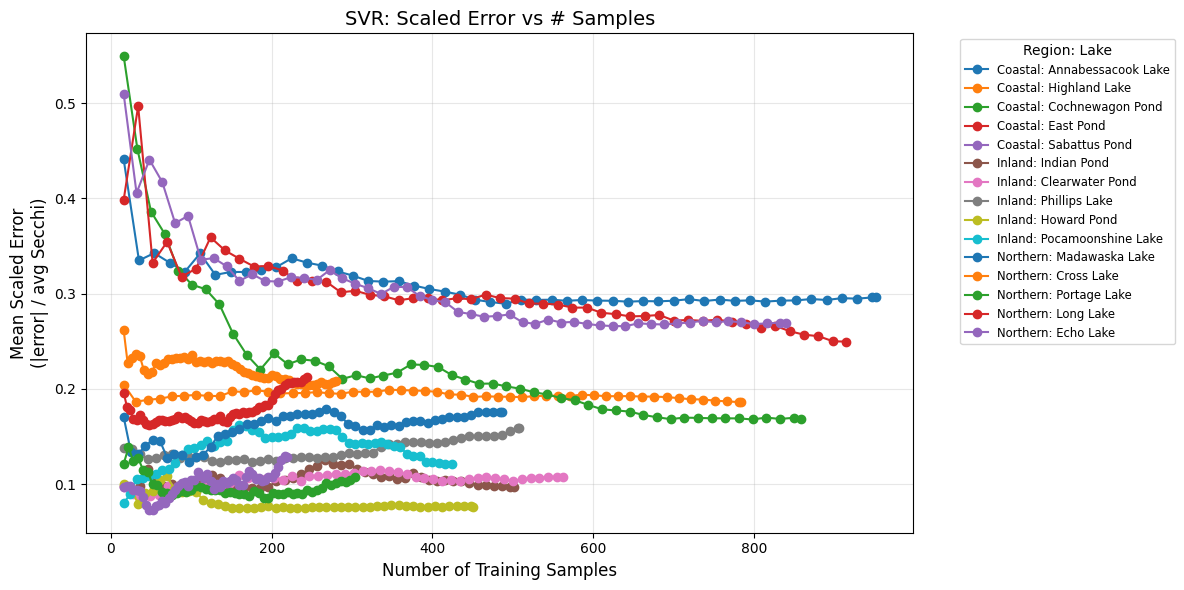

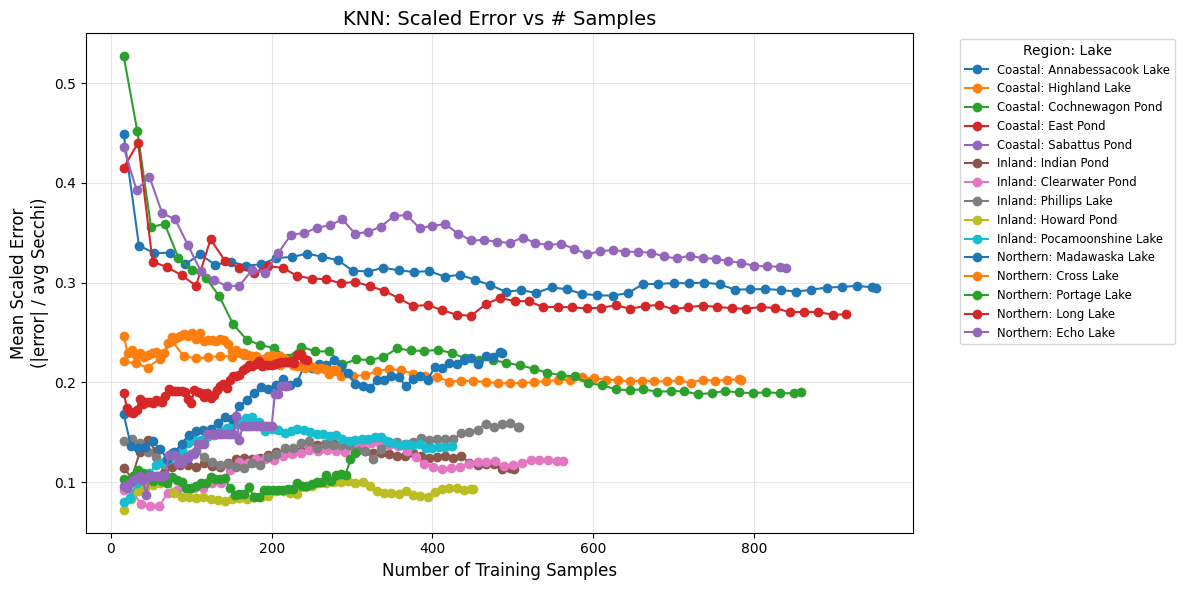

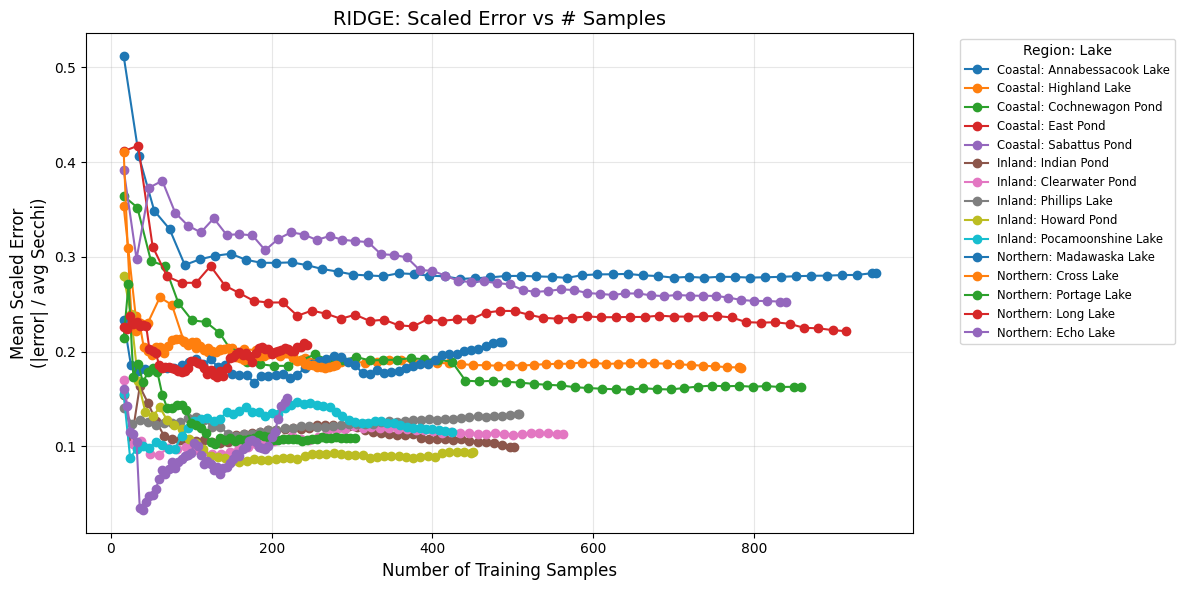

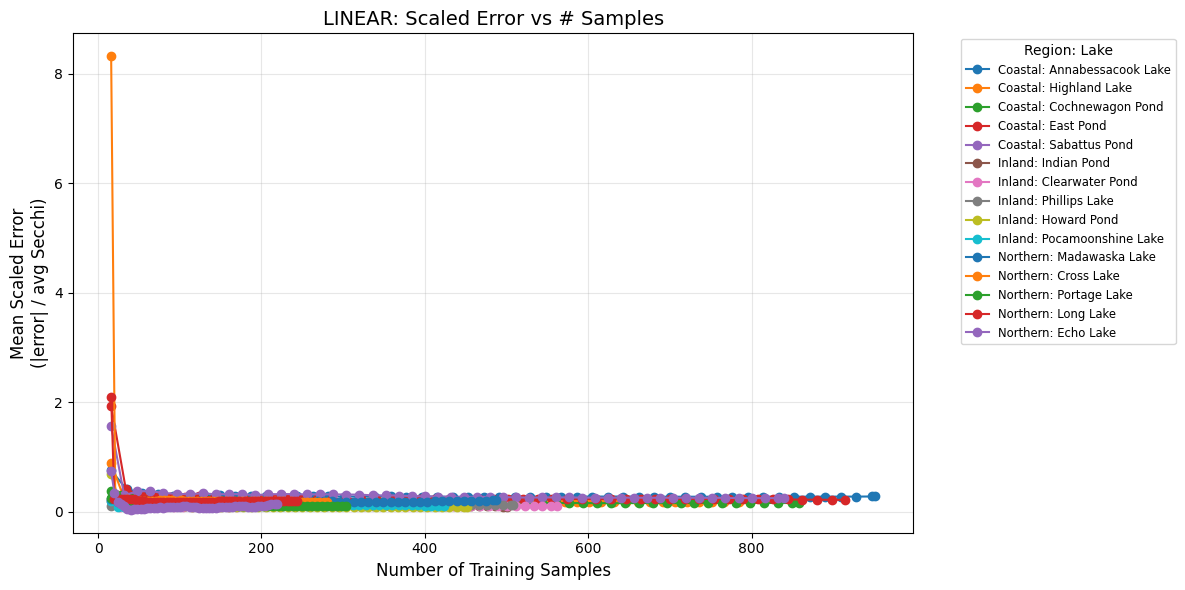

=== Final Scaled Errors by Lake ===
model                    knn    linear        rf     ridge       svr       xgb
midas                                                                         
Pocamoonshine Lake  0.136462  0.115495  0.110705  0.115518  0.121022  0.135242
Portage Lake        0.129324  0.108869  0.090146  0.108864  0.107211  0.100736
Cross Lake          0.212670  0.185728  0.211974  0.185762  0.208101  0.208538
Long Lake           0.222764  0.207424  0.215011  0.207491  0.212998  0.217134
Echo Lake           0.196040  0.152853  0.227860  0.151319  0.128172  0.290873
Madawaska Lake      0.230046  0.209749  0.187375  0.209715  0.175990  0.191075
Indian Pond         0.113599  0.099378  0.100325  0.099293  0.097008  0.114240
Howard Pond         0.092748  0.093756  0.085219  0.093752  0.076547  0.105384
Highland Lake       0.202696  0.183303  0.197624  0.183309  0.186206  0.205124
Sabattus Pond       0.314352  0.253173  0.256947  0.252890  0.269039  0.263373
Cochnewagon Pond

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# -------------------------------------------------------------------
# 0. impute_data (MICE)
# -------------------------------------------------------------------
def impute_data(df, midas_list, random_state=42):
    df = df.replace(['NA','Na','N/A','--','?','N',pd.NA], np.nan)
    imp = IterativeImputer(random_state=random_state, max_iter=10, sample_posterior=True)
    nonnum = ['MIDAS','SAMPDATE']
    out = {}
    for midas in midas_list:
        sub = df[df['MIDAS']==midas].copy()
        nums = sub.drop(columns=nonnum, errors='ignore')
        nums = nums.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
        if nums.shape[1]==0: continue
        arr = imp.fit_transform(nums)
        sub[nums.columns] = arr
        out[midas] = sub
    return out

# -------------------------------------------------------------------
# 1. Load class file & pad MIDAS codes
# -------------------------------------------------------------------
# Adjust the path as needed:
class_df = pd.read_csv(
    "/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy of Class_Final_LakeNames.csv"
)

# Ensure MIDAS codes are zero-padded to 4 digits:
class_df['MIDAS_code'] = class_df['MIDAS'].astype(str).str.zfill(4)


# -------------------------------------------------------------------
# 2. Pick best station per lake‐code from raw df
# -------------------------------------------------------------------
raw_counts = df['MIDAS'].value_counts().to_dict()
prefix_to_stations = defaultdict(list)
for st in raw_counts:
    code = st.lstrip('c').split('-')[0]
    prefix_to_stations[code].append(st)
best_station = {
    code: max(lst, key=lambda s: raw_counts.get(s,0))
    for code,lst in prefix_to_stations.items()
}

# -------------------------------------------------------------------
# 3. Per‐Region: select top 5 lakes by raw count
# -------------------------------------------------------------------
region_selected = {}
for region, grp in class_df.groupby('Region'):
    codes = grp['MIDAS_code'].unique()
    codes = [c for c in codes if c in best_station]
    codes = sorted(codes, key=lambda c: raw_counts[best_station[c]], reverse=True)[:5]
    region_selected[region] = [best_station[c] for c in codes]

# flatten for imputation & experimentation
selected_stations = sum(region_selected.values(), [])

# -------------------------------------------------------------------
# 4. Impute
# -------------------------------------------------------------------
imputed_by_lake = impute_data(df, selected_stations)

# -------------------------------------------------------------------
# 5. Features & models
# -------------------------------------------------------------------
features = [
    'SECCBOT','TMAX','TMIN','DOMAX','DOMIN',
    'MLD','OXIC','SCHMIDT','TPEC','TPBG',
    'CHLA','PH','COLOR','CONDUCT','ALK'
]
models = {
    'rf':    lambda: RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1),
    'xgb':   lambda: XGBRegressor(n_estimators=50, max_depth=3, verbosity=0),
    'svr':   SVR,
    'knn':   KNeighborsRegressor,
    'ridge': Ridge,
    'linear':LinearRegression
}

# build name map (title‐case)
name_map = dict(zip(
    class_df['MIDAS_code'],
    class_df['LakeName'].str.title()
))
def midas_to_name(m):
    code = m.lstrip('c').split('-')[0].zfill(4)
    return name_map.get(code, code)

# -------------------------------------------------------------------
# 6. Run plateau + scaled‐error experiment, grouping legend by Region
# -------------------------------------------------------------------
summary_scaled = []
summary_samples = []

for model_name, MConstructor in models.items():
    plt.figure(figsize=(12,6))
    for region, stations in region_selected.items():
        for midas in stations:
            df_l = imputed_by_lake.get(midas)
            if df_l is None: continue

            df_l['SAMPDATE'] = pd.to_datetime(df_l['SAMPDATE'])
            df_l.sort_values('SAMPDATE', inplace=True)
            df_l['year'] = df_l['SAMPDATE'].dt.year

            max_y = df_l['year'].max()
            test_years = range(max_y-4, max_y+1)
            test_df = df_l[df_l['year'].isin(test_years)]
            if test_df.empty: continue

            y_test = test_df['SECCHI'].values
            mean_test = y_test.mean()

            pre_df = df_l[~df_l['year'].isin(test_years)]
            total_pre = len(pre_df)
            min_n = len(features)+1
            step = max(1, total_pre//50)
            sample_ns = list(range(min_n, total_pre+1, step))
            if sample_ns[-1]!=total_pre: sample_ns.append(total_pre)

            scaled_means = []
            for n in sample_ns:
                tr = pre_df.iloc[-n:]
                X_tr = tr[features].apply(
                    lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
                ).values
                X_te = test_df[features].apply(
                    lambda c: pd.factorize(c)[0] if c.dtype=='object' else c
                ).values
                y_tr = tr['SECCHI'].values

                valid = ~np.isnan(X_tr).all(axis=0)
                X_tr, X_te = X_tr[:,valid], X_te[:,valid]

                imp = SimpleImputer(strategy='mean')
                X_tr = imp.fit_transform(X_tr)
                X_te = imp.transform(X_te)

                m = MConstructor()
                m.fit(X_tr, y_tr)
                y_pred = m.predict(X_te)
                scaled_means.append(np.abs(y_test-y_pred).mean()/mean_test)

            if not scaled_means: continue

            df_res = pd.DataFrame({'n':sample_ns,'scaled_err':scaled_means})
            lake_name = midas_to_name(midas)
            plt.plot(df_res['n'], df_res['scaled_err'],
                     marker='o',
                     label=f"{region}: {lake_name}")

            # record final & plateau
            summary_scaled.append({
                'midas': midas, 'model': model_name,
                'scaled_err_all': df_res['scaled_err'].iloc[-1]
            })
            base = df_res['scaled_err'].iloc[-1]
            thr = base*1.05
            cand = df_res[df_res['scaled_err']<=thr]['n']
            plateau = cand.min() if not cand.empty else sample_ns[-1]
            summary_samples.append({
                'midas': midas, 'model': model_name,
                'plateau_samples': plateau
            })

    plt.xlabel("Number of Training Samples", fontsize=12)
    plt.ylabel("Mean Scaled Error\n(|error| / avg Secchi)", fontsize=12)
    plt.title(f"{model_name.upper()}: Scaled Error vs # Samples", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small', title="Region: Lake")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 7. Summaries
# -------------------------------------------------------------------
sf = pd.DataFrame(summary_scaled).pivot(index='midas', columns='model', values='scaled_err_all')
ss = pd.DataFrame(summary_samples).pivot(index='midas', columns='model', values='plateau_samples')

sf_named = sf.rename(index=midas_to_name)
ss_named = ss.rename(index=midas_to_name)

print("=== Final Scaled Errors by Lake ===")
print(sf_named, "\n")
print("=== Plateau Samples by Lake ===")
print(ss_named)

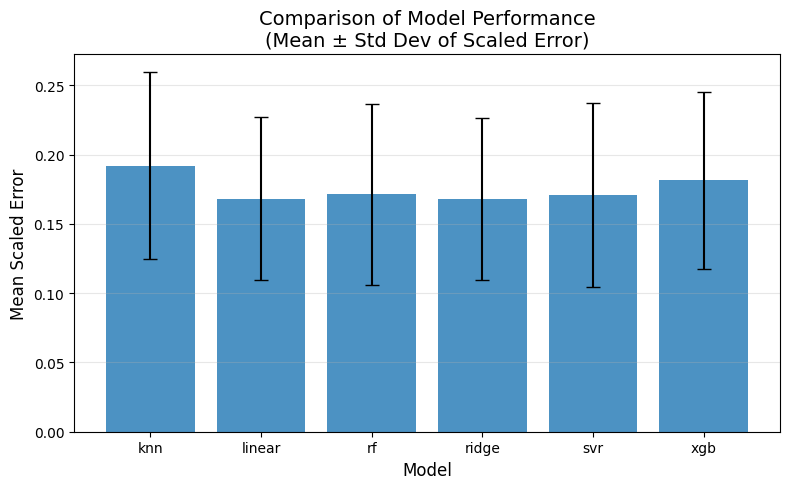

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already run the pivot step and have:
#   sf = pd.DataFrame(summary_scaled).pivot(index='midas', columns='model', values='scaled_err_all')
# If you renamed to lake names, use sf_named instead.

# 1. Compute per‐model mean and standard deviation of the final scaled errors
model_means = sf.mean(axis=0)
model_stds  = sf.std(axis=0)

# 2. Bar plot with error bars
plt.figure(figsize=(8, 5))
plt.bar(
    model_means.index,
    model_means.values,
    yerr=model_stds.values,
    capsize=5,
    alpha=0.8
)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Mean Scaled Error", fontsize=12)
plt.title("Comparison of Model Performance\n(Mean ± Std Dev of Scaled Error)", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Ablation Study

In [ ]:
!nvidia-smi

Wed Jul  2 03:46:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Ablation Study MAE per Lake:
         depth_only  depth_schmidt  depth_schmidt_temp
lake                                                  
c9961-1    1.241398       1.238841            1.173656
c3734-1    0.876311       0.864731            0.866198
c3814-1    1.536705       1.517186            1.507404
c5349-1    1.181654       1.181898            1.153635
c3796-1    0.840738       0.842127            0.835866
c5240-1    0.601325       0.599460            0.599701
c5236-1    1.215247       1.204483            1.195028
c3188-1    0.699502       0.690882            0.689000
c3234-1    0.598499       0.585433            0.578833
c3832-1    0.875287       0.871659            0.816766
c5382-1    0.488332       0.488782            0.490241
c5448-1    1.315759       1.301214            1.285451
c3750-1    0.606551       0.598922            0.597954
c3134-1    0.863336       0.842126            0.842636
c3480-1    0.874694       0.851794            0.852470
c5307-1    0.645097       0.631389  

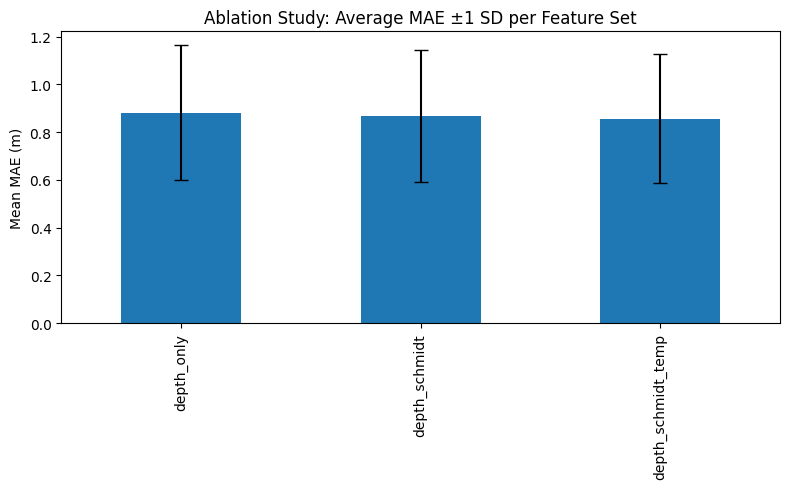

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1) Load auxiliary lake‐level max depths
depth_df = pd.read_excel('/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy Computed_Data_clean_for lake names.xlsx')
depth_map = depth_df.groupby('modified_midas')['Depth'].max().to_dict()

# 2) Load raw Secchi data
raw_df = pd.read_excel(
    '/content/drive/MyDrive/Colby Lake Research/Rishit\'s Copy of SecchiDataDJW.xlsx',
    sheet_name='data', engine='openpyxl'
)

# 3) Preprocess flags & timestamps
raw_df['SECCBOT'] = raw_df['SECCBOT'].map({'Y': 1, 'N': 0})
raw_df['SAMPDATE'] = pd.to_datetime(raw_df['SAMPDATE'], utc=True)

# 4) Derive lake‐level ID (strip station suffix) & map depths
raw_df['modified_midas'] = raw_df['MIDAS'].astype(str).str.split('-', n=1).str[0]
raw_df['LAKE_DEPTH'] = raw_df['modified_midas'].map(depth_map)
raw_df = raw_df.dropna(subset=['LAKE_DEPTH'])  # drop lakes w/o depth

# Updated objective with quadratic penalty for negatives
def negative_penalty(preds, dtrain):
    # Handle dtrain being DMatrix or numpy array of labels
    if hasattr(dtrain, 'get_label'):
        labels = dtrain.get_label()
    else:
        labels = dtrain

    errors = preds - labels
    # Base squared-error gradient/Hessian
    grad = 2 * errors
    hess = 2 * np.ones_like(preds)

    # Quadratic penalty for preds < 0: penalty = lambda_neg * (pred)^2
    lambda_neg = 1.0  # scale for the negative penalty
    mask = preds < 0
    # gradient of lambda_neg * pred^2 is 2 * lambda_neg * pred
    grad[mask] += 2 * lambda_neg * preds[mask]
    # hessian of lambda_neg * pred^2 is 2 * lambda_neg
    hess[mask] += 2 * lambda_neg

    return grad, hess

# 6) Select top 30 lakes
top30 = raw_df['MIDAS'].value_counts().nlargest(30).index.tolist()

# 7) Ablation feature sets
feature_sets = {
    'depth_only': ['LAKE_DEPTH'],
    'depth_schmidt': ['LAKE_DEPTH', 'SCHMIDT'],
    'depth_schmidt_temp': ['LAKE_DEPTH', 'SCHMIDT', 'TMAX']
}

# 8) Prepare results container
results = {'lake': []}
for key in feature_sets:
    results[key] = []

# 9) Loop per lake
for lake in top30:
    df = raw_df[raw_df['MIDAS'] == lake].copy()

    # Impute SCHMIDT & TMAX via GPU XGBoost with negative-value penalty
    for feat in ['SCHMIDT', 'TMAX']:
        obs_mask = df[feat].notna()
        if obs_mask.sum() > 10:
            xgb = XGBRegressor(
                n_estimators=150,
                objective=negative_penalty,
                tree_method='gpu_hist',
                gpu_id=0,
                predictor='gpu_predictor',
                random_state=42,
                verbosity=0
            )
            X_train = df.loc[obs_mask, ['LAKE_DEPTH']].values
            y_train = df.loc[obs_mask, feat].values
            xgb.fit(X_train, y_train)
            X_pred = df.loc[~obs_mask, ['LAKE_DEPTH']].values
            preds = xgb.predict(X_pred)
            # ensure non-negative
            df.loc[~obs_mask, feat] = np.maximum(preds, 0)

    # # Drop any rows still missing key fields
    # df = df.dropna(subset=['SECCHI', 'LAKE_DEPTH', 'SCHMIDT', 'TMAX'])
    # # if len(df) < 5:
    # #     continue  # skip if too few samples

    # 5-fold Ridge ablation
    y = df['SECCHI'].values
    kf = KFold(n_splits=10, shuffle=True, random_state=25)
    for key, feats in feature_sets.items():
        maes = []
        X = df[feats].values
        for train_idx, test_idx in kf.split(X):
            model = RidgeCV(alphas=np.logspace(-3, 3, 7))
            model.fit(X[train_idx], y[train_idx])
            preds = model.predict(X[test_idx])
            maes.append(mean_absolute_error(y[test_idx], preds))
        results[key].append(np.mean(maes))

    results['lake'].append(lake)

# 10) Compile & display results
res_df = pd.DataFrame(results).set_index('lake')
print("Ablation Study MAE per Lake:")
print(res_df)

# Compute mean and standard deviation across lakes
avg_mae = res_df.mean()
std_mae = res_df.std()

# Print summary stats
print("\nAverage MAE across the 30 lakes for each feature set:")
print(avg_mae)
print("\nStandard deviation of MAE across the 30 lakes:")
print(std_mae)

# Plot with error bars (±1 SD)
plt.figure(figsize=(8, 5))
avg_mae.plot(kind='bar', yerr=std_mae, capsize=5)
plt.ylabel('Mean MAE (m)')
plt.title('Ablation Study: Average MAE ±1 SD per Feature Set')
plt.tight_layout()
plt.show()

# Missing Data Visualization

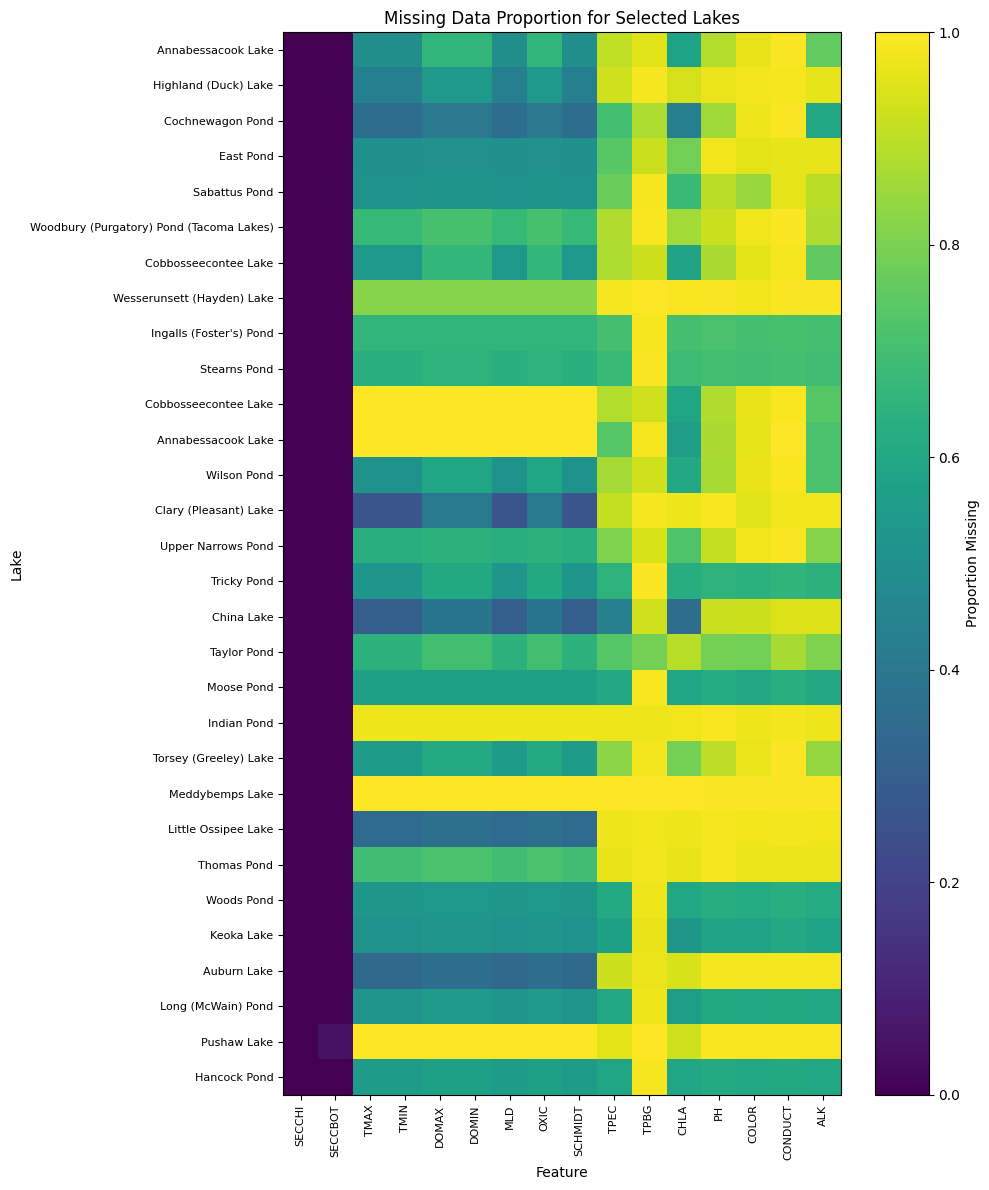

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your Secchi data
secchi_path = r"/content/drive/MyDrive/Colby Lake Research/Rishit's Copy of SecchiDataDJW.xlsx"
df = pd.read_excel(secchi_path, sheet_name='data', engine='openpyxl')

# 2. Compute missing‐data proportions per lake as before
features = [
    'SECCHI', 'SECCBOT', 'TMAX', 'TMIN', 'DOMAX', 'DOMIN',
    'MLD', 'OXIC', 'SCHMIDT', 'TPEC', 'TPBG',
    'CHLA', 'PH', 'COLOR', 'CONDUCT', 'ALK'
]
missing_matrix = df.groupby('MIDAS')[features].apply(lambda x: x.isna().mean())

# 3. Subset to your list of MIDAS IDs
subset_midas = [
    'c9961-1', 'c3734-1', 'c3814-1', 'c5349-1', 'c3796-1', 'c5240-1',
    'c5236-1', 'c70-1',   'c3188-1', 'c3234-1', 'c5236-2','c9961-2',
    'c3832-1', 'c5382-1', 'c98-1',   'c3382-1','c5448-1','c3750-1',
    'c3134-1','c3480-1','c5307-1','c177-2','c5024-1','c3392-1',
    'c3456-1','c3416-1','c3748-1','c3418-1','c80-1','c3132-1'
]
missing_sub = missing_matrix.loc[subset_midas].dropna(how='all')

# 4. Load geometry/morphometry file and build a mapping
geo_path = r"/content/drive/MyDrive/Colby Lake Research/Rishit MaineLakes_Geography_Morphometry.xls"
geo = pd.read_excel(geo_path, sheet_name='DATA', dtype={'Lake Code (MIDAS)': str})

# Ensure codes are zero‐padded to four digits
geo['Lake Code (MIDAS)'] = geo['Lake Code (MIDAS)'].str.zfill(4)
# Build a dict: code → lake name
name_map = dict(zip(geo['Lake Code (MIDAS)'], geo['Lake Name']))

# 5. Extract the numeric MIDAS (before the hyphen), pad, and map to names
def midas_to_name(midas_str):
    # get digits after 'c' and before '-'
    num = midas_str.lower().split('c')[-1].split('-')[0]
    code4 = num.zfill(4)
    return name_map.get(code4, midas_str)  # fallback to original if no match

lake_names = [midas_to_name(m) for m in missing_sub.index]

# 6. Re‐plot with lake names on the y‐axis
plt.figure(figsize=(10, 12))
plt.imshow(missing_sub.values, aspect='auto', cmap='viridis')
plt.yticks(range(len(lake_names)), lake_names, fontsize=8)
plt.xticks(range(len(features)), features, rotation=90, fontsize=8)
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Lake', fontsize=10)
plt.title('Missing Data Proportion for Selected Lakes', fontsize=12)
cbar = plt.colorbar(label='Proportion Missing')
plt.tight_layout()
plt.show()

                                    LakeName FullyMissingFeatures
0                         Annabessacook Lake                 None
1                       Highland (Duck) Lake                 None
2                           Cochnewagon Pond                 None
3                                  East Pond                 None
4                              Sabattus Pond                 None
5   Woodbury (Purgatory) Pond (Tacoma Lakes)                 None
6                       Cobbosseecontee Lake                 None
7                 Wesserunsett (Hayden) Lake                 None
8                    Ingalls (Foster's) Pond                 None
9                               Stearns Pond                 None
10                      Cobbosseecontee Lake                 TMAX
11                        Annabessacook Lake                 TMAX
12                               Wilson Pond                 None
13                     Clary (Pleasant) Lake                 None
14        

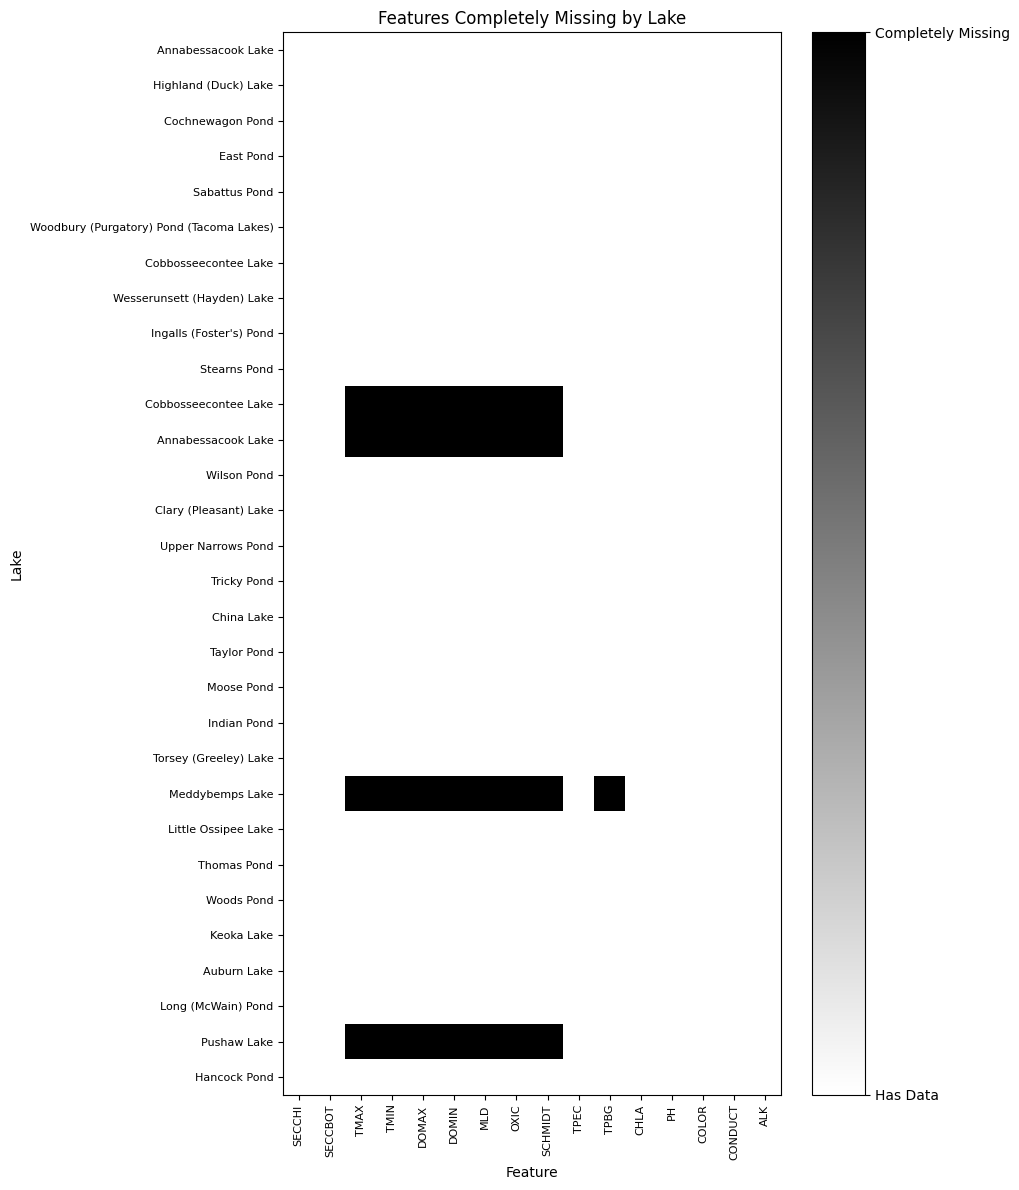

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# ASSUME: df is already loaded as your full Secchi‐data DataFrame.
# ----------------------------------------------------------------

# 1) Define your 30 lakes and features
subset_midas = [
    'c9961-1','c3734-1','c3814-1','c5349-1','c3796-1','c5240-1',
    'c5236-1','c70-1','c3188-1','c3234-1','c5236-2','c9961-2',
    'c3832-1','c5382-1','c98-1','c3382-1','c5448-1','c3750-1',
    'c3134-1','c3480-1','c5307-1','c177-2','c5024-1','c3392-1',
    'c3456-1','c3416-1','c3748-1','c3418-1','c80-1','c3132-1'
]
features = [
    'SECCHI','SECCBOT','TMAX','TMIN','DOMAX','DOMIN',
    'MLD','OXIC','SCHMIDT','TPEC','TPBG',
    'CHLA','PH','COLOR','CONDUCT','ALK'
]

# 2) Compute fraction missing per lake/feature
missing_matrix = (
    df.groupby('MIDAS')[features]
      .apply(lambda x: x.isna().mean())
)

# 3) Reindex to ensure all 30 appear (missing → 1.0)
missing_sub = missing_matrix.reindex(subset_midas).fillna(1.0)

# 4) Build summary: features 100% missing for each lake
fully_missing_dict = {
    lake: list(missing_sub.columns[missing_sub.loc[lake] == 1.0])
    for lake in missing_sub.index
}
summary_df = (
    pd.DataFrame.from_dict(fully_missing_dict, orient='index')
      .rename_axis('MIDAS')
      .reset_index()
      .rename(columns={0: 'FullyMissingFeatures'})
)

# 5) Load geography/morphometry and build MIDAS→Name map
geo_path = r"/content/drive/MyDrive/Colby Lake Research/Rishit MaineLakes_Geography_Morphometry.xls"
geo = pd.read_excel(geo_path, sheet_name='DATA', dtype={'Lake Code (MIDAS)': str})
geo['Lake Code (MIDAS)'] = geo['Lake Code (MIDAS)'].str.zfill(4)
name_map = dict(zip(geo['Lake Code (MIDAS)'], geo['Lake Name']))

def midas_to_name(midas_str):
    num = midas_str.lower().split('c')[-1].split('-')[0]
    return name_map.get(num.zfill(4), midas_str)

# 6) Apply mapping to summary_df
summary_df['LakeName'] = summary_df['MIDAS'].map(midas_to_name)

# 7) Display summary with real names
print(summary_df[['LakeName','FullyMissingFeatures']])

# 8) Create binary mask & map index → names for plotting
binary_mask = (missing_sub == 1.0).astype(int)
lake_names = [midas_to_name(m) for m in binary_mask.index]

plt.figure(figsize=(10, 12))
plt.imshow(binary_mask.values, aspect='auto', cmap='gray_r')
plt.yticks(range(len(lake_names)), lake_names, fontsize=8)
plt.xticks(range(len(features)), features, rotation=90, fontsize=8)
plt.xlabel('Feature')
plt.ylabel('Lake')
plt.title('Features Completely Missing by Lake')
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['Has Data', 'Completely Missing'])
plt.tight_layout()
plt.show()